# Simulations of the cell-line-specifc ER+ *PIK3CA* mutant breast cancer dynamic network models in Zanudo et al. 2002

This notebook uses the compiled JAR file in the repository (*dist* directory in https://github.com/jgtz/BreastCancerModelv2/), and executes it through Python.

In [1]:
from subprocess import Popen, PIPE, STDOUT
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image
%pylab inline
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
pylab.rcParams['figure.figsize'] = (2.7, 1.5);mpl.rcParams['lines.linewidth'] = 2;mpl.rcParams['lines.markersize'] = 5;
pylab.rcParams['lines.markeredgewidth'] =  0.5;matplotlib.rcParams.update({'font.size': 12})

These functions allow us to call the JAR file, generate the files needed to run the model (e.g. the Boolean tables), run simulations, and read the files generated by the simulations.

In [3]:
def run_BCmodel(parameters, jar_path,quiet=False):
    proc = Popen(['java', '-jar', jar_path]+parameters, stdout=PIPE, stderr=STDOUT)
    with proc.stdout:
        for line in iter(proc.stdout.readline, b''):
            if quiet:
                continue
            sys.stdout.write(line)
            
def generate_BCmodel(filename, jar_path,quiet=False):
    proc = Popen(['java', '-jar', jar_path]+["Generate",filename], stdout=PIPE, stderr=STDOUT)
    with proc.stdout:
        for line in iter(proc.stdout.readline, b''):
            if quiet:
                continue
            sys.stdout.write(line)
            
def get_parameters(filename,initial_conditions,normalized_time_steps,write_timecourse,perturbation_nodes=[],perturbation_states=[]):
    #The JAR file expect the following arguments. Curently we only support perturbations of up to size 4 through this method.
    
    #args[0] is the mode in which to run the program. Options: "Run", "Generate", "GenerateAndRun", "BreastCancerModel_ZanudoEtAl2017"
    #args[1] is the name of the TXT file where the model is.
    #args[2] is the number of initial conditions to run.
    #args[3] is the number of normalized time steps (number of timesteps equal to the average time needed to update a slow node) to run.
    #args[4] Whether to write to file the . Takes the values (without quotes) "true" or "false".
    #args[5] is the node name of the first perturbation, args[6] is the state of the first perturbation
    #args[7] is the node name of the second perturbation, args[8] is the state of the second perturbation
    #args[9] is the node name of the third perturbation, args[10] is the state of the third perturbation
    #args[11] is the node name of the fourth perturbation, args[12] is the state of the fourth perturbation
    parameters=["Run",filename,str(initial_conditions),str(normalized_time_steps),write_timecourse]
    
    
    if(len(perturbation_nodes)!=len(perturbation_states)):
        raise Exception("Error: perturbation_nodes and perturbation_nodes must have the same length")
    
    if(len(perturbation_nodes)>4):
        raise Exception("Error: Only up to 4 perturbations are allowed")
    
    for n,s in zip(perturbation_nodes,perturbation_states):
        parameters.append(n)
        parameters.append(s)

    return(parameters)
            
def get_parametersold(filename,initial_conditions,normalized_time_steps,write_timecourse,perturbation_node_1=None,perturbation_state_1=None,perturbation_node_2=None,perturbation_state_2=None,perturbation_node_3=None,perturbation_state_3=None,perturbation_node_4=None,perturbation_state_4=None):
    #args[0] is the mode in which to run the program. Options: "Run", "Generate", "GenerateAndRun", "BreastCancerModel_ZanudoEtAl2017"
    #args[1] is the name of the TXT file where the model is.
    #args[2] is the number of initial conditions to run.
    #args[3] is the number of normalized time steps (number of timesteps equal to the average time needed to update a slow node) to run.
    #args[4] Whether to write to file the . Takes the values (without quotes) "true" or "false".
    #args[5] is the node name of the first perturbation, args[6] is the state of the first perturbation
    #args[7] is the node name of the second perturbation, args[8] is the state of the second perturbation
    #args[9] is the node name of the third perturbation, args[10] is the state of the third perturbation
    #args[11] is the node name of the fourth perturbation, args[12] is the state of the fourth perturbation
    parameters=["Run",filename,str(initial_conditions),str(normalized_time_steps),write_timecourse]
    if(perturbation_node_1 is not None):
        parameters.append(perturbation_node_1)
        parameters.append(perturbation_state_1)
        if(perturbation_node_2 is not None):
            parameters.append(perturbation_node_2)
            parameters.append(perturbation_state_2)
            if(perturbation_node_3 is not None):
                parameters.append(perturbation_node_3)
                parameters.append(perturbation_state_3)
                if(perturbation_node_4 is not None):
                    parameters.append(perturbation_node_4)
                    parameters.append(perturbation_state_4)
    return(parameters)

def read_in_timecourse(basename,perturbation_nodes,perturbation_states,timecourses_directory="timecourses/"):
    perturbation_string="_".join([x[0]+"="+x[1] for x in zip(perturbation_nodes,perturbation_states)])
    if(perturbation_string!=""):
        timecourse_file_name='timecourse'+basename+"_"+perturbation_string+'.txt'
    else:
        timecourse_file_name='timecourse'+basename+perturbation_string+'.txt'
    df=pd.read_csv(timecourses_directory+timecourse_file_name,sep='\t',index_col=0)
    df=df.dropna(axis=1)
    df=df.append(pd.DataFrame(data=[df.columns],index=["time"],columns=df.columns,dtype="float64"))
    df.columns=[i for i,j in enumerate(df.columns)]
    df_timecourse=df
    return(df_timecourse)

Here we specify the parameters needed for the simulation:

- The path of the JAR file.
- The location of the model files.
- The number of initial conditions for the simulations.
- The number of time steps for each simulation.
- Whether to output a file with the average state of each node at every time step. 

In [4]:
jar_path="../dist/BreastCancerModel.jar"
#filename="models/BreastCancerModel_ZanudoEtAl2017.booleannet"
filename_model_M="../Models/BreastCancerModel_ZanudoEtAl2020_MCF7.booleannet"
filename_model_T="../Models/BreastCancerModel_ZanudoEtAl2020_T47D.booleannet"
initial_conditions=10000
normalized_time_steps=25
write_timecourse="true"

We first need to generate the Boolean tables of the model, which will then be used to run the timecourse simulations.

In [5]:
generate_BCmodel(filename_model_M,jar_path)
generate_BCmodel(filename_model_T,jar_path)


Filename: ../Models/BreastCancerModel_ZanudoEtAl2020_MCF7.booleannet
Creating Boolean table directory: BreastCancerModel_ZanudoEtAl2020_MCF7
Boolean table directory created.
Functions and names files created.
Creating network model...
Model created.
Exiting program

Filename: ../Models/BreastCancerModel_ZanudoEtAl2020_T47D.booleannet
Creating Boolean table directory: BreastCancerModel_ZanudoEtAl2020_T47D
Boolean table directory created.
Functions and names files created.
Creating network model...
Model created.
Exiting program


# Model simulations

We now run each of the cell-line-specific models (MCF7, T47D) in the presence of different perturbations starting from the cancerous state of each of the models. To run these simulations, we need 3 files that specify (1) the initial conditions, (2) the fast and slow nodes of the simulation, and (3) the weights for determining $Apoptosis_{norm}$ and $Proliferation_{norm}$.

**Initial conditions**

The initial conditions are specified in the *ModelName_InitialConditions.txt* files, where *ModelName* is either *BreastCancerModel_ZanudoEtAl2020_MCF7* or *BreastCancerModel_ZanudoEtAl2020_T47D*.

**Fast and slow nodes**

The slow and fast nodes are specified in the *ModelName_SlowFastNodes.txt* files. The file contains the name of the slow nodes and the fast nodes are taken to be the ones not specified in this file.

**Weights for $Apoptosis_{norm}$ and $Proliferation_{norm}$**

The weights are specified in the *ModelName_ApoptosisProliferationWeights.txt* files. Each row is tab-separated. The first row has the weights of $Apoptosis_{norm}$ in the following order: weight for Apoptosis=1, weight for Apoptosis=2, and weight for Apoptosis=3. The second row has the weights of $Proliferation_{norm}$ in the following order: weight for Prolfieration=1, weight for Proliferation=2, weight for Proliferation=3, and weight for Proliferation=4.

Note: For these models we set the weight for Proliferation=4 to be 0, since the maximum state of Proliferation is 3. The Zanudo et al. 2017 has a Proliferation=4 state, and in that case the associated weight would not be 0.

We first run the case in the abscence of perturbations

In [6]:
parameters=get_parameters(filename_model_M,initial_conditions,normalized_time_steps,write_timecourse)
run_BCmodel(parameters, jar_path,quiet=False)
parameters=get_parameters(filename_model_T,initial_conditions,normalized_time_steps,write_timecourse)
run_BCmodel(parameters, jar_path,quiet=False)


Filename: ../Models/BreastCancerModel_ZanudoEtAl2020_MCF7.booleannet
Creating network model based on Boolean tables, functions, and names files...
Model created.
Perturbation	Apofrac1	Apofrac2	Apofrac3	Apofrac	Prolfrac1	Prolfrac2	Prolfrac3	Prolfrac4	Prolfrac
No Perturbation	0.0	0.0	0.0	0.0	1.0	1.0	1.0	0.0	1.0

Filename: ../Models/BreastCancerModel_ZanudoEtAl2020_T47D.booleannet
Creating network model based on Boolean tables, functions, and names files...
Model created.
Perturbation	Apofrac1	Apofrac2	Apofrac3	Apofrac	Prolfrac1	Prolfrac2	Prolfrac3	Prolfrac4	Prolfrac
No Perturbation	0.0	0.0	0.0	0.0	1.0	1.0	1.0	0.0	1.0


We now select the perturbations we will run simulations for and then run the simulations

In [7]:
PerturbationNodes_list=[]
PerturbationStates_list=[]

perturbation_nodes=["Alpelisib"]
perturbation_states=["1"]
PerturbationNodes_list.append(perturbation_nodes)
PerturbationStates_list.append(perturbation_states)

perturbation_nodes=["Alpelisib","FOXO3"]
perturbation_states=["1","0"]
PerturbationNodes_list.append(perturbation_nodes)
PerturbationStates_list.append(perturbation_states)

perturbation_nodes=["Alpelisib","Fulvestrant"]
perturbation_states=["1","1"]
PerturbationNodes_list.append(perturbation_nodes)
PerturbationStates_list.append(perturbation_states)

perturbation_nodes=["Alpelisib","Palbociclib"]
perturbation_states=["1","1"]
PerturbationNodes_list.append(perturbation_nodes)
PerturbationStates_list.append(perturbation_states)

perturbation_nodes=["Alpelisib","Everolimus"]
perturbation_states=["1","1"]
PerturbationNodes_list.append(perturbation_nodes)
PerturbationStates_list.append(perturbation_states)

perturbation_nodes=["Alpelisib","Ipatasertib"]
perturbation_states=["1","1"]
PerturbationNodes_list.append(perturbation_nodes)
PerturbationStates_list.append(perturbation_states)

perturbation_nodes=["Navitoclax"]
perturbation_states=["1"]
PerturbationNodes_list.append(perturbation_nodes)
PerturbationStates_list.append(perturbation_states)

perturbation_nodes=["S63845"]
perturbation_states=["1"]
PerturbationNodes_list.append(perturbation_nodes)
PerturbationStates_list.append(perturbation_states)

perturbation_nodes=["S63845","Navitoclax"]
perturbation_states=["1","1"]
PerturbationNodes_list.append(perturbation_nodes)
PerturbationStates_list.append(perturbation_states)

perturbation_nodes=["Alpelisib","S63845"]
perturbation_states=["1","1"]
PerturbationNodes_list.append(perturbation_nodes)
PerturbationStates_list.append(perturbation_states)

perturbation_nodes=["Alpelisib","Navitoclax"]
perturbation_states=["1","1"]
PerturbationNodes_list.append(perturbation_nodes)
PerturbationStates_list.append(perturbation_states)

perturbation_nodes=["Alpelisib","S63845","Navitoclax"]
perturbation_states=["1","1","1"]
PerturbationNodes_list.append(perturbation_nodes)
PerturbationStates_list.append(perturbation_states)

perturbation_nodes=["Alpelisib","p21_T","p21_T_2"]
perturbation_states=["1","0","0"]
PerturbationNodes_list.append(perturbation_nodes)
PerturbationStates_list.append(perturbation_states)

perturbation_nodes=["Alpelisib","p27_T"]
perturbation_states=["1","0"]
PerturbationNodes_list.append(perturbation_nodes)
PerturbationStates_list.append(perturbation_states)

perturbation_nodes=["Alpelisib","p21_p27_T"]
perturbation_states=["1","0"]
PerturbationNodes_list.append(perturbation_nodes)
PerturbationStates_list.append(perturbation_states)

perturbation_nodes=["Alpelisib","Rb_T"]
perturbation_states=["1","0"]
PerturbationNodes_list.append(perturbation_nodes)
PerturbationStates_list.append(perturbation_states)

perturbation_nodes=["Alpelisib","TSC"]
perturbation_states=["1","0"]
PerturbationNodes_list.append(perturbation_nodes)
PerturbationStates_list.append(perturbation_states)

perturbation_nodes=["Alpelisib","PTEN"]
perturbation_states=["1","0"]
PerturbationNodes_list.append(perturbation_nodes)
PerturbationStates_list.append(perturbation_states)

perturbation_nodes=["Alpelisib","MYC_2"]
perturbation_states=["1","1"]
PerturbationNodes_list.append(perturbation_nodes)
PerturbationStates_list.append(perturbation_states)

perturbation_nodes=["Alpelisib","SGK1"]
perturbation_states=["1","1"]
PerturbationNodes_list.append(perturbation_nodes)
PerturbationStates_list.append(perturbation_states)

perturbation_nodes=["Alpelisib","PIM"]
perturbation_states=["1","1"]
PerturbationNodes_list.append(perturbation_nodes)
PerturbationStates_list.append(perturbation_states)

perturbation_nodes=["Alpelisib","ER_microenvironment"]
perturbation_states=["1","1"]
PerturbationNodes_list.append(perturbation_nodes)
PerturbationStates_list.append(perturbation_states)

perturbation_nodes=["Alpelisib","IGF1R_T_2"]
perturbation_states=["1","1"]
PerturbationNodes_list.append(perturbation_nodes)
PerturbationStates_list.append(perturbation_states)

perturbation_nodes=["Alpelisib","HER2","HER3_T","HER3_microenvironment"]
perturbation_states=["1","1","1","1"]
PerturbationNodes_list.append(perturbation_nodes)
PerturbationStates_list.append(perturbation_states)

perturbation_nodes=["HER2","HER3_T","HER3_microenvironment"]
perturbation_states=["1","1","1"]
PerturbationNodes_list.append(perturbation_nodes)
PerturbationStates_list.append(perturbation_states)

perturbation_nodes=["Alpelisib","HER2","HER3_T"]
perturbation_states=["1","1","1"]
PerturbationNodes_list.append(perturbation_nodes)
PerturbationStates_list.append(perturbation_states)

perturbation_nodes=["Palbociclib","Rb_T"]
perturbation_states=["1","0"]
PerturbationNodes_list.append(perturbation_nodes)
PerturbationStates_list.append(perturbation_states)

perturbation_nodes=["Fulvestrant","Rb_T"]
perturbation_states=["1","0"]
PerturbationNodes_list.append(perturbation_nodes)
PerturbationStates_list.append(perturbation_states)

perturbation_nodes=["Palbociclib"]
perturbation_states=["1"]
PerturbationNodes_list.append(perturbation_nodes)
PerturbationStates_list.append(perturbation_states)

perturbation_nodes=["Fulvestrant"]
perturbation_states=["1"]
PerturbationNodes_list.append(perturbation_nodes)
PerturbationStates_list.append(perturbation_states)

perturbation_nodes=["Ipatasertib"]
perturbation_states=["1"]
PerturbationNodes_list.append(perturbation_nodes)
PerturbationStates_list.append(perturbation_states)

perturbation_nodes=["Everolimus"]
perturbation_states=["1"]
PerturbationNodes_list.append(perturbation_nodes)
PerturbationStates_list.append(perturbation_states)

perturbation_nodes=["Palbociclib","Fulvestrant"]
perturbation_states=["1","1"]
PerturbationNodes_list.append(perturbation_nodes)
PerturbationStates_list.append(perturbation_states)

perturbation_nodes=["Fulvestrant","MYC_2"]
perturbation_states=["1","1"]
PerturbationNodes_list.append(perturbation_nodes)
PerturbationStates_list.append(perturbation_states)

In [8]:
for perturbation_nodes,perturbation_states in zip(PerturbationNodes_list,PerturbationStates_list):
    parameters=get_parameters(filename_model_M,initial_conditions,normalized_time_steps,write_timecourse,perturbation_nodes,perturbation_states)
    run_BCmodel(parameters, jar_path,quiet=False)
    parameters=get_parameters(filename_model_T,initial_conditions,normalized_time_steps,write_timecourse,perturbation_nodes,perturbation_states)
    run_BCmodel(parameters, jar_path,quiet=False)


Filename: ../Models/BreastCancerModel_ZanudoEtAl2020_MCF7.booleannet
Creating network model based on Boolean tables, functions, and names files...
Model created.
Perturbation	Apofrac1	Apofrac2	Apofrac3	Apofrac	Prolfrac1	Prolfrac2	Prolfrac3	Prolfrac4	Prolfrac
Alpelisib=1	1.0	0.0	0.0	0.25	1.0	8.0E-4	1.0E-4	0.0	0.250275

Filename: ../Models/BreastCancerModel_ZanudoEtAl2020_T47D.booleannet
Creating network model based on Boolean tables, functions, and names files...
Model created.
Perturbation	Apofrac1	Apofrac2	Apofrac3	Apofrac	Prolfrac1	Prolfrac2	Prolfrac3	Prolfrac4	Prolfrac
Alpelisib=1	1.0	0.0	0.0	0.125	1.0	8.0E-4	1.0E-4	0.0	0.250275

Filename: ../Models/BreastCancerModel_ZanudoEtAl2020_MCF7.booleannet
Creating network model based on Boolean tables, functions, and names files...
Model created.
Perturbation1	Perturbation2	Apofrac1	Apofrac2	Apofrac3	Apofrac	Prolfrac1	Prolfrac2	Prolfrac3	Prolfrac4	Prolfrac
Alpelisib=1	FOXO3=0	0.3363	0.0	0.0	0.084075	1.0	1.0	0.0	0.0	0.5

Filename: ../Models

Model created.
Perturbation1	Perturbation2	Perturbation3	Apofrac1	Apofrac2	Apofrac3	Apofrac	Prolfrac1	Prolfrac2	Prolfrac3	Prolfrac4	Prolfrac
Alpelisib=1	p21_T=0	p21_T_2=0	1.0	0.0	0.0	0.25	1.0	8.0E-4	1.0E-4	0.0	0.250275

Filename: ../Models/BreastCancerModel_ZanudoEtAl2020_T47D.booleannet
Creating network model based on Boolean tables, functions, and names files...
Model created.
Perturbation1	Perturbation2	Perturbation3	Apofrac1	Apofrac2	Apofrac3	Apofrac	Prolfrac1	Prolfrac2	Prolfrac3	Prolfrac4	Prolfrac
Alpelisib=1	p21_T=0	p21_T_2=0	1.0	0.0	0.0	0.125	1.0	8.0E-4	1.0E-4	0.0	0.250275

Filename: ../Models/BreastCancerModel_ZanudoEtAl2020_MCF7.booleannet
Creating network model based on Boolean tables, functions, and names files...
Model created.
Perturbation1	Perturbation2	Apofrac1	Apofrac2	Apofrac3	Apofrac	Prolfrac1	Prolfrac2	Prolfrac3	Prolfrac4	Prolfrac
Alpelisib=1	p27_T=0	1.0	0.0	0.0	0.25	1.0	8.0E-4	1.0E-4	0.0	0.250275

Filename: ../Models/BreastCancerModel_ZanudoEtAl2020_T47D.booleannet


HER2=1	HER3_T=1	HER3_microenvironment=1	0.0	0.0	0.0	0.0	1.0	1.0	1.0	0.0	1.0

Filename: ../Models/BreastCancerModel_ZanudoEtAl2020_T47D.booleannet
Creating network model based on Boolean tables, functions, and names files...
Model created.
Perturbation1	Perturbation2	Perturbation3	Apofrac1	Apofrac2	Apofrac3	Apofrac	Prolfrac1	Prolfrac2	Prolfrac3	Prolfrac4	Prolfrac
HER2=1	HER3_T=1	HER3_microenvironment=1	0.0	0.0	0.0	0.0	1.0	1.0	1.0	0.0	1.0

Filename: ../Models/BreastCancerModel_ZanudoEtAl2020_MCF7.booleannet
Creating network model based on Boolean tables, functions, and names files...
Model created.
Perturbation1	Perturbation2	Perturbation3	Apofrac1	Apofrac2	Apofrac3	Apofrac	Prolfrac1	Prolfrac2	Prolfrac3	Prolfrac4	Prolfrac
Alpelisib=1	HER2=1	HER3_T=1	0.9939	0.0	0.0	0.248475	1.0	0.7078	0.4248	0.0	0.66345

Filename: ../Models/BreastCancerModel_ZanudoEtAl2020_T47D.booleannet
Creating network model based on Boolean tables, functions, and names files...
Model created.
Perturbation1	Perturbatio

# Timecourse data and dataframes

The $Apoptosis_{norm}$ and $Proliferation_{norm}$ for each perturbation and cell-specific-model will be output in the *BreastCancerModel_ZanudoEtAl2020.csv* file. This file contains all the model results used for Fig. 7, Supplemental Figure S4-S6.

We first move all the generated timecourse files to the *timecourses* folder

In [9]:
import shutil

source = './'
dest1 = './timecourses'

files = os.listdir(source)

for f in files:
    bnfile=os.path.basename(f)
    if bnfile.startswith("timecourseBreastCancerModel"):
        #print(bnfile)
        shutil.copy(source+f, dest1)
        os.remove(source+f)
    if bnfile.startswith("timecourseSEMBreastCancerModel"):
        #print(bnfile)
        shutil.copy(source+f, dest1)
        os.remove(source+f)

This is an example of how one of the timecourse files looks like. Each column has the average state of each of nodes in all the simulations at the given normalized_time_steps. The normalized_time_step is given by the *time* row.

In [10]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
basename=os.path.basename(filename_model_M).split(".")[0]
perturbation_nodes=[]
perturbation_states=[]
df_timecourse=read_in_timecourse(basename,perturbation_nodes,perturbation_states)
df_timecourse

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,...,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124
ER_transcription_feedback_2,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
ER_transcription_feedback_1,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
HER3_microenvironment,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
ER_microenvironment,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
ER_transcripti

We now read the timecourse files and save them in a pandas dataframe. We will use the dataframe to plot the timecourse and the $Apoptosis_{norm}$ and $Proliferation_{norm}$ for each perturbation.

In [11]:
basename=os.path.basename(filename_model_M).split(".")[0]

perturbation_nodes=[]
perturbation_states=[]
df_timecourse=read_in_timecourse(basename,perturbation_nodes,perturbation_states)
df_timecourse_alpelisib_0_M=df_timecourse.T

perturbation_nodes=["Alpelisib"]
perturbation_states=["1"]
df_timecourse=read_in_timecourse(basename,perturbation_nodes,perturbation_states)
df_timecourse_alpelisib_1_M=df_timecourse.T

perturbation_nodes=["Alpelisib","FOXO3"]
perturbation_states=["1","0"]
df_timecourse=read_in_timecourse(basename,perturbation_nodes,perturbation_states)
df_timecourse_alpelisib_1_foxo3_0_M=df_timecourse.T

perturbation_nodes=["Alpelisib","Rb_T"]
perturbation_states=["1","0"]
df_timecourse=read_in_timecourse(basename,perturbation_nodes,perturbation_states)
df_timecourse_alpelisib_1_RbT_0_M=df_timecourse.T

perturbation_nodes=["Alpelisib","MYC_2"]
perturbation_states=["1","1"]
df_timecourse=read_in_timecourse(basename,perturbation_nodes,perturbation_states)
df_timecourse_alpelisib_1_MYC2_1_M=df_timecourse.T

perturbation_nodes=["Fulvestrant","MYC_2"]
perturbation_states=["1","1"]
df_timecourse=read_in_timecourse(basename,perturbation_nodes,perturbation_states)
df_timecourse_fulvestrant_1_MYC2_1_M=df_timecourse.T

perturbation_nodes=["Alpelisib","Fulvestrant"]
perturbation_states=["1","1"]
df_timecourse=read_in_timecourse(basename,perturbation_nodes,perturbation_states)
df_timecourse_alpelisib_1_fulvestrant_1_M=df_timecourse.T

perturbation_nodes=["Alpelisib","Palbociclib"]
perturbation_states=["1","1"]
df_timecourse=read_in_timecourse(basename,perturbation_nodes,perturbation_states)
df_timecourse_alpelisib_1_palbociclib_1_M=df_timecourse.T

perturbation_nodes=["Everolimus"]
perturbation_states=["1"]
df_timecourse=read_in_timecourse(basename,perturbation_nodes,perturbation_states)
df_timecourse_everolimus_1_M=df_timecourse.T

perturbation_nodes=["Ipatasertib"]
perturbation_states=["1"]
df_timecourse=read_in_timecourse(basename,perturbation_nodes,perturbation_states)
df_timecourse_ipatasertib_1_M=df_timecourse.T

perturbation_nodes=["Alpelisib","Everolimus"]
perturbation_states=["1","1"]
df_timecourse=read_in_timecourse(basename,perturbation_nodes,perturbation_states)
df_timecourse_alpelisib_1_everolimus_1_M=df_timecourse.T

perturbation_nodes=["Alpelisib","Ipatasertib"]
perturbation_states=["1","1"]
df_timecourse=read_in_timecourse(basename,perturbation_nodes,perturbation_states)
df_timecourse_alpelisib_1_ipatasertib_1_M=df_timecourse.T

perturbation_nodes=["Navitoclax"]
perturbation_states=["1","1"]
df_timecourse=read_in_timecourse(basename,perturbation_nodes,perturbation_states)
df_timecourse_Navitoclax_1_M=df_timecourse.T

perturbation_nodes=["S63845"]
perturbation_states=["1"]
df_timecourse=read_in_timecourse(basename,perturbation_nodes,perturbation_states)
df_timecourse_S63845_1_M=df_timecourse.T

perturbation_nodes=["S63845","Navitoclax"]
perturbation_states=["1","1"]
df_timecourse=read_in_timecourse(basename,perturbation_nodes,perturbation_states)
df_timecourse_S63845_1_Navitoclax_1_M=df_timecourse.T

perturbation_nodes=["Alpelisib","S63845"]
perturbation_states=["1","1"]
df_timecourse=read_in_timecourse(basename,perturbation_nodes,perturbation_states)
df_timecourse_alpelisib_1_S63845_1_M=df_timecourse.T

perturbation_nodes=["Alpelisib","Navitoclax"]
perturbation_states=["1","1"]
df_timecourse=read_in_timecourse(basename,perturbation_nodes,perturbation_states)
df_timecourse_alpelisib_1_Navitoclax_1_M=df_timecourse.T

perturbation_nodes=["Alpelisib","S63845","Navitoclax"]
perturbation_states=["1","1","1"]
df_timecourse=read_in_timecourse(basename,perturbation_nodes,perturbation_states)
df_timecourse_alpelisib_1_S63845_1_Navitoclax_1_M=df_timecourse.T

perturbation_nodes=["Alpelisib","p21_p27_T"]
perturbation_states=["1","0"]
df_timecourse=read_in_timecourse(basename,perturbation_nodes,perturbation_states)
df_timecourse_alpelisib_1_P21P27T_0_M=df_timecourse.T

perturbation_nodes=["Alpelisib","p21_T","p21_T_2"]
perturbation_states=["1","0","0"]
df_timecourse=read_in_timecourse(basename,perturbation_nodes,perturbation_states)
df_timecourse_alpelisib_1_P21T_0_M=df_timecourse.T

perturbation_nodes=["Alpelisib","p27_T"]
perturbation_states=["1","0"]
df_timecourse=read_in_timecourse(basename,perturbation_nodes,perturbation_states)
df_timecourse_alpelisib_1_P27T_0_M=df_timecourse.T

perturbation_nodes=["Alpelisib","TSC"]
perturbation_states=["1","0"]
df_timecourse=read_in_timecourse(basename,perturbation_nodes,perturbation_states)
df_timecourse_alpelisib_1_TSC_0_M=df_timecourse.T

perturbation_nodes=["Alpelisib","PTEN"]
perturbation_states=["1","0"]
df_timecourse=read_in_timecourse(basename,perturbation_nodes,perturbation_states)
df_timecourse_alpelisib_1_PTEN_0_M=df_timecourse.T

perturbation_nodes=["Alpelisib","SGK1"]
perturbation_states=["1","1"]
df_timecourse=read_in_timecourse(basename,perturbation_nodes,perturbation_states)
df_timecourse_alpelisib_1_SGK1_1_M=df_timecourse.T

perturbation_nodes=["Alpelisib","PIM"]
perturbation_states=["1","1"]
df_timecourse=read_in_timecourse(basename,perturbation_nodes,perturbation_states)
df_timecourse_alpelisib_1_PIM1_1_M=df_timecourse.T

perturbation_nodes=["Alpelisib","ER_microenvironment"]
perturbation_states=["1","1"]
df_timecourse=read_in_timecourse(basename,perturbation_nodes,perturbation_states)
df_timecourse_alpelisib_1_ERmicroenvironment_1_M=df_timecourse.T

perturbation_nodes=["Alpelisib","IGF1R_T_2"]
perturbation_states=["1","1"]
df_timecourse=read_in_timecourse(basename,perturbation_nodes,perturbation_states)
df_timecourse_alpelisib_1_IGFR1_2_M=df_timecourse.T

perturbation_nodes=["Alpelisib","HER2","HER3_T","HER3_microenvironment"]
perturbation_states=["1","1","1","1"]
df_timecourse=read_in_timecourse(basename,perturbation_nodes,perturbation_states)
df_timecourse_alpelisib_1_HER3microenvironment_1_M=df_timecourse.T

perturbation_nodes=["Palbociclib","Rb_T"]
perturbation_states=["1","0"]
df_timecourse=read_in_timecourse(basename,perturbation_nodes,perturbation_states)
df_timecourse_palbociclib_1_RbT_0_M=df_timecourse.T

perturbation_nodes=["Fulvestrant","Rb_T"]
perturbation_states=["1","0"]
df_timecourse=read_in_timecourse(basename,perturbation_nodes,perturbation_states)
df_timecourse_fulvestrant_1_RbT_0_M=df_timecourse.T

perturbation_nodes=["Palbociclib","Fulvestrant"]
perturbation_states=["1","1"]
df_timecourse=read_in_timecourse(basename,perturbation_nodes,perturbation_states)
df_timecourse_palbociclib_1_fulvestrant_1_M=df_timecourse.T

perturbation_nodes=["Fulvestrant"]
perturbation_states=["1"]
df_timecourse=read_in_timecourse(basename,perturbation_nodes,perturbation_states)
df_timecourse_fulvestrant_1_M=df_timecourse.T

perturbation_nodes=["Palbociclib"]
perturbation_states=["1"]
df_timecourse=read_in_timecourse(basename,perturbation_nodes,perturbation_states)
df_timecourse_palbociclib_1_M=df_timecourse.T

In [12]:
basename=os.path.basename(filename_model_T).split(".")[0]

perturbation_nodes=[]
perturbation_states=[]
df_timecourse=read_in_timecourse(basename,perturbation_nodes,perturbation_states)
df_timecourse_alpelisib_0_T=df_timecourse.T

perturbation_nodes=["Alpelisib"]
perturbation_states=["1"]
df_timecourse=read_in_timecourse(basename,perturbation_nodes,perturbation_states)
df_timecourse_alpelisib_1_T=df_timecourse.T

perturbation_nodes=["Alpelisib","FOXO3"]
perturbation_states=["1","0"]
df_timecourse=read_in_timecourse(basename,perturbation_nodes,perturbation_states)
df_timecourse_alpelisib_1_foxo3_0_T=df_timecourse.T

perturbation_nodes=["Alpelisib","Rb_T"]
perturbation_states=["1","0"]
df_timecourse=read_in_timecourse(basename,perturbation_nodes,perturbation_states)
df_timecourse_alpelisib_1_RbT_0_T=df_timecourse.T

perturbation_nodes=["Alpelisib","MYC_2"]
perturbation_states=["1","1"]
df_timecourse=read_in_timecourse(basename,perturbation_nodes,perturbation_states)
df_timecourse_alpelisib_1_MYC2_1_T=df_timecourse.T

perturbation_nodes=["Fulvestrant","MYC_2"]
perturbation_states=["1","1"]
df_timecourse=read_in_timecourse(basename,perturbation_nodes,perturbation_states)
df_timecourse_fulvestrant_1_MYC2_1_T=df_timecourse.T

perturbation_nodes=["Alpelisib","Fulvestrant"]
perturbation_states=["1","1"]
df_timecourse=read_in_timecourse(basename,perturbation_nodes,perturbation_states)
df_timecourse_alpelisib_1_fulvestrant_1_T=df_timecourse.T

perturbation_nodes=["Alpelisib","Palbociclib"]
perturbation_states=["1","1"]
df_timecourse=read_in_timecourse(basename,perturbation_nodes,perturbation_states)
df_timecourse_alpelisib_1_palbociclib_1_T=df_timecourse.T

perturbation_nodes=["Everolimus"]
perturbation_states=["1"]
df_timecourse=read_in_timecourse(basename,perturbation_nodes,perturbation_states)
df_timecourse_everolimus_1_T=df_timecourse.T

perturbation_nodes=["Ipatasertib"]
perturbation_states=["1"]
df_timecourse=read_in_timecourse(basename,perturbation_nodes,perturbation_states)
df_timecourse_ipatasertib_1_T=df_timecourse.T

perturbation_nodes=["Alpelisib","Everolimus"]
perturbation_states=["1","1"]
df_timecourse=read_in_timecourse(basename,perturbation_nodes,perturbation_states)
df_timecourse_alpelisib_1_everolimus_1_T=df_timecourse.T

perturbation_nodes=["Alpelisib","Ipatasertib"]
perturbation_states=["1","1"]
df_timecourse=read_in_timecourse(basename,perturbation_nodes,perturbation_states)
df_timecourse_alpelisib_1_ipatasertib_1_T=df_timecourse.T

perturbation_nodes=["Navitoclax"]
perturbation_states=["1","1"]
df_timecourse=read_in_timecourse(basename,perturbation_nodes,perturbation_states)
df_timecourse_Navitoclax_1_T=df_timecourse.T

perturbation_nodes=["S63845"]
perturbation_states=["1"]
df_timecourse=read_in_timecourse(basename,perturbation_nodes,perturbation_states)
df_timecourse_S63845_1_T=df_timecourse.T

perturbation_nodes=["S63845","Navitoclax"]
perturbation_states=["1","1"]
df_timecourse=read_in_timecourse(basename,perturbation_nodes,perturbation_states)
df_timecourse_S63845_1_Navitoclax_1_T=df_timecourse.T

perturbation_nodes=["Alpelisib","S63845"]
perturbation_states=["1","1"]
df_timecourse=read_in_timecourse(basename,perturbation_nodes,perturbation_states)
df_timecourse_alpelisib_1_S63845_1_T=df_timecourse.T

perturbation_nodes=["Alpelisib","Navitoclax"]
perturbation_states=["1","1"]
df_timecourse=read_in_timecourse(basename,perturbation_nodes,perturbation_states)
df_timecourse_alpelisib_1_Navitoclax_1_T=df_timecourse.T

perturbation_nodes=["Alpelisib","S63845","Navitoclax"]
perturbation_states=["1","1","1"]
df_timecourse=read_in_timecourse(basename,perturbation_nodes,perturbation_states)
df_timecourse_alpelisib_1_S63845_1_Navitoclax_1_T=df_timecourse.T

perturbation_nodes=["Alpelisib","p21_p27_T"]
perturbation_states=["1","0"]
df_timecourse=read_in_timecourse(basename,perturbation_nodes,perturbation_states)
df_timecourse_alpelisib_1_P21P27T_0_T=df_timecourse.T

perturbation_nodes=["Alpelisib","p21_T","p21_T_2"]
perturbation_states=["1","0","0"]
df_timecourse=read_in_timecourse(basename,perturbation_nodes,perturbation_states)
df_timecourse_alpelisib_1_P21T_0_T=df_timecourse.T

perturbation_nodes=["Alpelisib","p27_T"]
perturbation_states=["1","0"]
df_timecourse=read_in_timecourse(basename,perturbation_nodes,perturbation_states)
df_timecourse_alpelisib_1_P27T_0_T=df_timecourse.T

perturbation_nodes=["Alpelisib","TSC"]
perturbation_states=["1","0"]
df_timecourse=read_in_timecourse(basename,perturbation_nodes,perturbation_states)
df_timecourse_alpelisib_1_TSC_0_T=df_timecourse.T

perturbation_nodes=["Alpelisib","PTEN"]
perturbation_states=["1","0"]
df_timecourse=read_in_timecourse(basename,perturbation_nodes,perturbation_states)
df_timecourse_alpelisib_1_PTEN_0_T=df_timecourse.T

perturbation_nodes=["Alpelisib","SGK1"]
perturbation_states=["1","1"]
df_timecourse=read_in_timecourse(basename,perturbation_nodes,perturbation_states)
df_timecourse_alpelisib_1_SGK1_1_T=df_timecourse.T

perturbation_nodes=["Alpelisib","PIM"]
perturbation_states=["1","1"]
df_timecourse=read_in_timecourse(basename,perturbation_nodes,perturbation_states)
df_timecourse_alpelisib_1_PIM1_1_T=df_timecourse.T

perturbation_nodes=["Alpelisib","ER_microenvironment"]
perturbation_states=["1","1"]
df_timecourse=read_in_timecourse(basename,perturbation_nodes,perturbation_states)
df_timecourse_alpelisib_1_ERmicroenvironment_1_T=df_timecourse.T

perturbation_nodes=["Alpelisib","IGF1R_T_2"]
perturbation_states=["1","1"]
df_timecourse=read_in_timecourse(basename,perturbation_nodes,perturbation_states)
df_timecourse_alpelisib_1_IGFR1_2_T=df_timecourse.T

perturbation_nodes=["Alpelisib","HER2","HER3_T","HER3_microenvironment"]
perturbation_states=["1","1","1","1"]
df_timecourse=read_in_timecourse(basename,perturbation_nodes,perturbation_states)
df_timecourse_alpelisib_1_HER3microenvironment_1_T=df_timecourse.T

perturbation_nodes=["Palbociclib","Rb_T"]
perturbation_states=["1","0"]
df_timecourse=read_in_timecourse(basename,perturbation_nodes,perturbation_states)
df_timecourse_palbociclib_1_RbT_0_T=df_timecourse.T

perturbation_nodes=["Fulvestrant","Rb_T"]
perturbation_states=["1","0"]
df_timecourse=read_in_timecourse(basename,perturbation_nodes,perturbation_states)
df_timecourse_fulvestrant_1_RbT_0_T=df_timecourse.T

perturbation_nodes=["Palbociclib","Fulvestrant"]
perturbation_states=["1","1"]
df_timecourse=read_in_timecourse(basename,perturbation_nodes,perturbation_states)
df_timecourse_palbociclib_1_fulvestrant_1_T=df_timecourse.T

perturbation_nodes=["Fulvestrant"]
perturbation_states=["1"]
df_timecourse=read_in_timecourse(basename,perturbation_nodes,perturbation_states)
df_timecourse_fulvestrant_1_T=df_timecourse.T

perturbation_nodes=["Palbociclib"]
perturbation_states=["1"]
df_timecourse=read_in_timecourse(basename,perturbation_nodes,perturbation_states)
df_timecourse_palbociclib_1_T=df_timecourse.T

We put all the from the perturbations in the df_model_results dataframe

In [13]:
Proliferation_norm=[]
Apoptosis_norm=[]
Perturbation=[]
Cell_line=[]

df_timecourse=df_timecourse_alpelisib_0_M
Proliferation_norm.append(df_timecourse.iloc[-1,]["Proliferation_norm"])
Apoptosis_norm.append(df_timecourse.iloc[-1,]["Apoptosis_norm"])
Perturbation.append("None")
Cell_line.append("MCF7")

df_timecourse=df_timecourse_alpelisib_1_M
Proliferation_norm.append(df_timecourse.iloc[-1,]["Proliferation_norm"])
Apoptosis_norm.append(df_timecourse.iloc[-1,]["Apoptosis_norm"])
Perturbation.append("Alpelisib")
Cell_line.append("MCF7")

df_timecourse=df_timecourse_alpelisib_1_foxo3_0_M
Proliferation_norm.append(df_timecourse.iloc[-1,]["Proliferation_norm"])
Apoptosis_norm.append(df_timecourse.iloc[-1,]["Apoptosis_norm"])
Perturbation.append("Alpelisib+FOXO3=0")
Cell_line.append("MCF7")

df_timecourse=df_timecourse_alpelisib_1_RbT_0_M
Proliferation_norm.append(df_timecourse.iloc[-1,]["Proliferation_norm"])
Apoptosis_norm.append(df_timecourse.iloc[-1,]["Apoptosis_norm"])
Perturbation.append("Alpelisib+Rb_T=0")
Cell_line.append("MCF7")

df_timecourse=df_timecourse_alpelisib_1_MYC2_1_M
Proliferation_norm.append(df_timecourse.iloc[-1,]["Proliferation_norm"])
Apoptosis_norm.append(df_timecourse.iloc[-1,]["Apoptosis_norm"])
Perturbation.append("Alpelisib+MYC=2")
Cell_line.append("MCF7")

df_timecourse=df_timecourse_fulvestrant_1_MYC2_1_M
Proliferation_norm.append(df_timecourse.iloc[-1,]["Proliferation_norm"])
Apoptosis_norm.append(df_timecourse.iloc[-1,]["Apoptosis_norm"])
Perturbation.append("Fulvestrant+MYC=2")
Cell_line.append("MCF7")

df_timecourse=df_timecourse_alpelisib_1_fulvestrant_1_M
Proliferation_norm.append(df_timecourse.iloc[-1,]["Proliferation_norm"])
Apoptosis_norm.append(df_timecourse.iloc[-1,]["Apoptosis_norm"])
Perturbation.append("Alpelisib+Fulvestrant")
Cell_line.append("MCF7")

df_timecourse=df_timecourse_alpelisib_1_palbociclib_1_M
Proliferation_norm.append(df_timecourse.iloc[-1,]["Proliferation_norm"])
Apoptosis_norm.append(df_timecourse.iloc[-1,]["Apoptosis_norm"])
Perturbation.append("Alpelisib+Palbociclib")
Cell_line.append("MCF7")

df_timecourse=df_timecourse_everolimus_1_M
Proliferation_norm.append(df_timecourse.iloc[-1,]["Proliferation_norm"])
Apoptosis_norm.append(df_timecourse.iloc[-1,]["Apoptosis_norm"])
Perturbation.append("Everolimus")
Cell_line.append("MCF7")

df_timecourse=df_timecourse_ipatasertib_1_M
Proliferation_norm.append(df_timecourse.iloc[-1,]["Proliferation_norm"])
Apoptosis_norm.append(df_timecourse.iloc[-1,]["Apoptosis_norm"])
Perturbation.append("Ipatasertib")
Cell_line.append("MCF7")

df_timecourse=df_timecourse_alpelisib_1_everolimus_1_M
Proliferation_norm.append(df_timecourse.iloc[-1,]["Proliferation_norm"])
Apoptosis_norm.append(df_timecourse.iloc[-1,]["Apoptosis_norm"])
Perturbation.append("Alpelisib+Everolimus")
Cell_line.append("MCF7")

df_timecourse=df_timecourse_alpelisib_1_ipatasertib_1_M
Proliferation_norm.append(df_timecourse.iloc[-1,]["Proliferation_norm"])
Apoptosis_norm.append(df_timecourse.iloc[-1,]["Apoptosis_norm"])
Perturbation.append("Alpelisib+Ipatasertib")
Cell_line.append("MCF7")

df_timecourse=df_timecourse_S63845_1_M
Proliferation_norm.append(df_timecourse.iloc[-1,]["Proliferation_norm"])
Apoptosis_norm.append(df_timecourse.iloc[-1,]["Apoptosis_norm"])
Perturbation.append("S63845")
Cell_line.append("MCF7")

df_timecourse=df_timecourse_Navitoclax_1_M
Proliferation_norm.append(df_timecourse.iloc[-1,]["Proliferation_norm"])
Apoptosis_norm.append(df_timecourse.iloc[-1,]["Apoptosis_norm"])
Perturbation.append("Navitoclax")
Cell_line.append("MCF7")

df_timecourse=df_timecourse_S63845_1_Navitoclax_1_M
Proliferation_norm.append(df_timecourse.iloc[-1,]["Proliferation_norm"])
Apoptosis_norm.append(df_timecourse.iloc[-1,]["Apoptosis_norm"])
Perturbation.append("S63845+Navitoclax")
Cell_line.append("MCF7")

df_timecourse=df_timecourse_alpelisib_1_S63845_1_M
Proliferation_norm.append(df_timecourse.iloc[-1,]["Proliferation_norm"])
Apoptosis_norm.append(df_timecourse.iloc[-1,]["Apoptosis_norm"])
Perturbation.append("Alpelisib+S63845")
Cell_line.append("MCF7")

df_timecourse=df_timecourse_alpelisib_1_Navitoclax_1_M
Proliferation_norm.append(df_timecourse.iloc[-1,]["Proliferation_norm"])
Apoptosis_norm.append(df_timecourse.iloc[-1,]["Apoptosis_norm"])
Perturbation.append("Alpelisib+Navitoclax")
Cell_line.append("MCF7")

df_timecourse=df_timecourse_alpelisib_1_S63845_1_Navitoclax_1_M
Proliferation_norm.append(df_timecourse.iloc[-1,]["Proliferation_norm"])
Apoptosis_norm.append(df_timecourse.iloc[-1,]["Apoptosis_norm"])
Perturbation.append("Alpelisib+S63845+Navitoclax")
Cell_line.append("MCF7")

df_timecourse=df_timecourse_alpelisib_1_P21P27T_0_M
Proliferation_norm.append(df_timecourse.iloc[-1,]["Proliferation_norm"])
Apoptosis_norm.append(df_timecourse.iloc[-1,]["Apoptosis_norm"])
Perturbation.append("Alpelisib+p21/p27_T=0")
Cell_line.append("MCF7")

df_timecourse=df_timecourse_alpelisib_1_P21T_0_M
Proliferation_norm.append(df_timecourse.iloc[-1,]["Proliferation_norm"])
Apoptosis_norm.append(df_timecourse.iloc[-1,]["Apoptosis_norm"])
Perturbation.append("Alpelisib+p21_T=0")
Cell_line.append("MCF7")

df_timecourse=df_timecourse_alpelisib_1_P27T_0_M
Proliferation_norm.append(df_timecourse.iloc[-1,]["Proliferation_norm"])
Apoptosis_norm.append(df_timecourse.iloc[-1,]["Apoptosis_norm"])
Perturbation.append("Alpelisib+p27_T=0")
Cell_line.append("MCF7")

df_timecourse=df_timecourse_alpelisib_1_TSC_0_M
Proliferation_norm.append(df_timecourse.iloc[-1,]["Proliferation_norm"])
Apoptosis_norm.append(df_timecourse.iloc[-1,]["Apoptosis_norm"])
Perturbation.append("Alpelisib+TSC=0")
Cell_line.append("MCF7")

df_timecourse=df_timecourse_alpelisib_1_PTEN_0_M
Proliferation_norm.append(df_timecourse.iloc[-1,]["Proliferation_norm"])
Apoptosis_norm.append(df_timecourse.iloc[-1,]["Apoptosis_norm"])
Perturbation.append("Alpelisib+PTEN=0")
Cell_line.append("MCF7")

df_timecourse=df_timecourse_alpelisib_1_SGK1_1_M
Proliferation_norm.append(df_timecourse.iloc[-1,]["Proliferation_norm"])
Apoptosis_norm.append(df_timecourse.iloc[-1,]["Apoptosis_norm"])
Perturbation.append("Alpelisib+SGK1=1")
Cell_line.append("MCF7")

df_timecourse=df_timecourse_alpelisib_1_PIM1_1_M
Proliferation_norm.append(df_timecourse.iloc[-1,]["Proliferation_norm"])
Apoptosis_norm.append(df_timecourse.iloc[-1,]["Apoptosis_norm"])
Perturbation.append("Alpelisib+PIM=1")
Cell_line.append("MCF7")

df_timecourse=df_timecourse_alpelisib_1_ERmicroenvironment_1_M
Proliferation_norm.append(df_timecourse.iloc[-1,]["Proliferation_norm"])
Apoptosis_norm.append(df_timecourse.iloc[-1,]["Apoptosis_norm"])
Perturbation.append("Alpelisib+ER_microenviroment=1")
Cell_line.append("MCF7")

df_timecourse=df_timecourse_alpelisib_1_IGFR1_2_M
Proliferation_norm.append(df_timecourse.iloc[-1,]["Proliferation_norm"])
Apoptosis_norm.append(df_timecourse.iloc[-1,]["Apoptosis_norm"])
Perturbation.append("Alpelisib+IGF1R_T=2")
Cell_line.append("MCF7")

df_timecourse=df_timecourse_alpelisib_1_HER3microenvironment_1_M
Proliferation_norm.append(df_timecourse.iloc[-1,]["Proliferation_norm"])
Apoptosis_norm.append(df_timecourse.iloc[-1,]["Apoptosis_norm"])
Perturbation.append("Alpelisib+HER3_microenviroment=1+HER3_T=1+HER2=1")
Cell_line.append("MCF7")

df_timecourse=df_timecourse_palbociclib_1_RbT_0_M
Proliferation_norm.append(df_timecourse.iloc[-1,]["Proliferation_norm"])
Apoptosis_norm.append(df_timecourse.iloc[-1,]["Apoptosis_norm"])
Perturbation.append("Palbociclib+Rb_T=0")
Cell_line.append("MCF7")

df_timecourse=df_timecourse_fulvestrant_1_RbT_0_M
Proliferation_norm.append(df_timecourse.iloc[-1,]["Proliferation_norm"])
Apoptosis_norm.append(df_timecourse.iloc[-1,]["Apoptosis_norm"])
Perturbation.append("Fulvestrant+Rb_T=0")
Cell_line.append("MCF7")

df_timecourse=df_timecourse_palbociclib_1_fulvestrant_1_M
Proliferation_norm.append(df_timecourse.iloc[-1,]["Proliferation_norm"])
Apoptosis_norm.append(df_timecourse.iloc[-1,]["Apoptosis_norm"])
Perturbation.append("Fulvestrant+Palbociclib")
Cell_line.append("MCF7")

df_timecourse=df_timecourse_fulvestrant_1_M
Proliferation_norm.append(df_timecourse.iloc[-1,]["Proliferation_norm"])
Apoptosis_norm.append(df_timecourse.iloc[-1,]["Apoptosis_norm"])
Perturbation.append("Fulvestrant")
Cell_line.append("MCF7")

df_timecourse=df_timecourse_palbociclib_1_M
Proliferation_norm.append(df_timecourse.iloc[-1,]["Proliferation_norm"])
Apoptosis_norm.append(df_timecourse.iloc[-1,]["Apoptosis_norm"])
Perturbation.append("Palbociclib")
Cell_line.append("MCF7")

df_timecourse=df_timecourse_alpelisib_0_T
Proliferation_norm.append(df_timecourse.iloc[-1,]["Proliferation_norm"])
Apoptosis_norm.append(df_timecourse.iloc[-1,]["Apoptosis_norm"])
Perturbation.append("None")
Cell_line.append("T47D")

df_timecourse=df_timecourse_alpelisib_1_T
Proliferation_norm.append(df_timecourse.iloc[-1,]["Proliferation_norm"])
Apoptosis_norm.append(df_timecourse.iloc[-1,]["Apoptosis_norm"])
Perturbation.append("Alpelisib")
Cell_line.append("T47D")

df_timecourse=df_timecourse_alpelisib_1_foxo3_0_T
Proliferation_norm.append(df_timecourse.iloc[-1,]["Proliferation_norm"])
Apoptosis_norm.append(df_timecourse.iloc[-1,]["Apoptosis_norm"])
Perturbation.append("Alpelisib+FOXO3=0")
Cell_line.append("T47D")

df_timecourse=df_timecourse_alpelisib_1_RbT_0_T
Proliferation_norm.append(df_timecourse.iloc[-1,]["Proliferation_norm"])
Apoptosis_norm.append(df_timecourse.iloc[-1,]["Apoptosis_norm"])
Perturbation.append("Alpelisib+Rb_T=0")
Cell_line.append("T47D")

df_timecourse=df_timecourse_alpelisib_1_MYC2_1_T
Proliferation_norm.append(df_timecourse.iloc[-1,]["Proliferation_norm"])
Apoptosis_norm.append(df_timecourse.iloc[-1,]["Apoptosis_norm"])
Perturbation.append("Alpelisib+MYC=2")
Cell_line.append("T47D")

df_timecourse=df_timecourse_fulvestrant_1_MYC2_1_T
Proliferation_norm.append(df_timecourse.iloc[-1,]["Proliferation_norm"])
Apoptosis_norm.append(df_timecourse.iloc[-1,]["Apoptosis_norm"])
Perturbation.append("Fulvestrant+MYC=2")
Cell_line.append("T47D")

df_timecourse=df_timecourse_alpelisib_1_fulvestrant_1_T
Proliferation_norm.append(df_timecourse.iloc[-1,]["Proliferation_norm"])
Apoptosis_norm.append(df_timecourse.iloc[-1,]["Apoptosis_norm"])
Perturbation.append("Alpelisib+Fulvestrant")
Cell_line.append("T47D")

df_timecourse=df_timecourse_alpelisib_1_palbociclib_1_T
Proliferation_norm.append(df_timecourse.iloc[-1,]["Proliferation_norm"])
Apoptosis_norm.append(df_timecourse.iloc[-1,]["Apoptosis_norm"])
Perturbation.append("Alpelisib+Palbociclib")
Cell_line.append("T47D")

df_timecourse=df_timecourse_everolimus_1_T
Proliferation_norm.append(df_timecourse.iloc[-1,]["Proliferation_norm"])
Apoptosis_norm.append(df_timecourse.iloc[-1,]["Apoptosis_norm"])
Perturbation.append("Everolimus")
Cell_line.append("T47D")

df_timecourse=df_timecourse_ipatasertib_1_T
Proliferation_norm.append(df_timecourse.iloc[-1,]["Proliferation_norm"])
Apoptosis_norm.append(df_timecourse.iloc[-1,]["Apoptosis_norm"])
Perturbation.append("Ipatasertib")
Cell_line.append("T47D")

df_timecourse=df_timecourse_alpelisib_1_everolimus_1_T
Proliferation_norm.append(df_timecourse.iloc[-1,]["Proliferation_norm"])
Apoptosis_norm.append(df_timecourse.iloc[-1,]["Apoptosis_norm"])
Perturbation.append("Alpelisib+Everolimus")
Cell_line.append("T47D")

df_timecourse=df_timecourse_alpelisib_1_ipatasertib_1_T
Proliferation_norm.append(df_timecourse.iloc[-1,]["Proliferation_norm"])
Apoptosis_norm.append(df_timecourse.iloc[-1,]["Apoptosis_norm"])
Perturbation.append("Alpelisib+Ipatasertib")
Cell_line.append("T47D")

df_timecourse=df_timecourse_S63845_1_T
Proliferation_norm.append(df_timecourse.iloc[-1,]["Proliferation_norm"])
Apoptosis_norm.append(df_timecourse.iloc[-1,]["Apoptosis_norm"])
Perturbation.append("S63845")
Cell_line.append("T47D")

df_timecourse=df_timecourse_Navitoclax_1_T
Proliferation_norm.append(df_timecourse.iloc[-1,]["Proliferation_norm"])
Apoptosis_norm.append(df_timecourse.iloc[-1,]["Apoptosis_norm"])
Perturbation.append("Navitoclax")
Cell_line.append("T47D")

df_timecourse=df_timecourse_S63845_1_Navitoclax_1_T
Proliferation_norm.append(df_timecourse.iloc[-1,]["Proliferation_norm"])
Apoptosis_norm.append(df_timecourse.iloc[-1,]["Apoptosis_norm"])
Perturbation.append("S63845+Navitoclax")
Cell_line.append("T47D")

df_timecourse=df_timecourse_alpelisib_1_S63845_1_T
Proliferation_norm.append(df_timecourse.iloc[-1,]["Proliferation_norm"])
Apoptosis_norm.append(df_timecourse.iloc[-1,]["Apoptosis_norm"])
Perturbation.append("Alpelisib+S63845")
Cell_line.append("T47D")

df_timecourse=df_timecourse_alpelisib_1_Navitoclax_1_T
Proliferation_norm.append(df_timecourse.iloc[-1,]["Proliferation_norm"])
Apoptosis_norm.append(df_timecourse.iloc[-1,]["Apoptosis_norm"])
Perturbation.append("Alpelisib+Navitoclax")
Cell_line.append("T47D")

df_timecourse=df_timecourse_alpelisib_1_S63845_1_Navitoclax_1_T
Proliferation_norm.append(df_timecourse.iloc[-1,]["Proliferation_norm"])
Apoptosis_norm.append(df_timecourse.iloc[-1,]["Apoptosis_norm"])
Perturbation.append("Alpelisib+S63845+Navitoclax")
Cell_line.append("T47D")

df_timecourse=df_timecourse_alpelisib_1_P21P27T_0_T
Proliferation_norm.append(df_timecourse.iloc[-1,]["Proliferation_norm"])
Apoptosis_norm.append(df_timecourse.iloc[-1,]["Apoptosis_norm"])
Perturbation.append("Alpelisib+p21/p27_T=0")
Cell_line.append("T47D")

df_timecourse=df_timecourse_alpelisib_1_P21T_0_T
Proliferation_norm.append(df_timecourse.iloc[-1,]["Proliferation_norm"])
Apoptosis_norm.append(df_timecourse.iloc[-1,]["Apoptosis_norm"])
Perturbation.append("Alpelisib+p21_T=0")
Cell_line.append("T47D")

df_timecourse=df_timecourse_alpelisib_1_P27T_0_T
Proliferation_norm.append(df_timecourse.iloc[-1,]["Proliferation_norm"])
Apoptosis_norm.append(df_timecourse.iloc[-1,]["Apoptosis_norm"])
Perturbation.append("Alpelisib+p27_T=0")
Cell_line.append("T47D")

df_timecourse=df_timecourse_alpelisib_1_TSC_0_T
Proliferation_norm.append(df_timecourse.iloc[-1,]["Proliferation_norm"])
Apoptosis_norm.append(df_timecourse.iloc[-1,]["Apoptosis_norm"])
Perturbation.append("Alpelisib+TSC=0")
Cell_line.append("T47D")

df_timecourse=df_timecourse_alpelisib_1_PTEN_0_T
Proliferation_norm.append(df_timecourse.iloc[-1,]["Proliferation_norm"])
Apoptosis_norm.append(df_timecourse.iloc[-1,]["Apoptosis_norm"])
Perturbation.append("Alpelisib+PTEN=0")
Cell_line.append("T47D")

df_timecourse=df_timecourse_alpelisib_1_SGK1_1_T
Proliferation_norm.append(df_timecourse.iloc[-1,]["Proliferation_norm"])
Apoptosis_norm.append(df_timecourse.iloc[-1,]["Apoptosis_norm"])
Perturbation.append("Alpelisib+SGK1=1")
Cell_line.append("T47D")

df_timecourse=df_timecourse_alpelisib_1_PIM1_1_T
Proliferation_norm.append(df_timecourse.iloc[-1,]["Proliferation_norm"])
Apoptosis_norm.append(df_timecourse.iloc[-1,]["Apoptosis_norm"])
Perturbation.append("Alpelisib+PIM=1")
Cell_line.append("T47D")

df_timecourse=df_timecourse_alpelisib_1_ERmicroenvironment_1_T
Proliferation_norm.append(df_timecourse.iloc[-1,]["Proliferation_norm"])
Apoptosis_norm.append(df_timecourse.iloc[-1,]["Apoptosis_norm"])
Perturbation.append("Alpelisib+ER_microenviroment=1")
Cell_line.append("T47D")

df_timecourse=df_timecourse_alpelisib_1_IGFR1_2_T
Proliferation_norm.append(df_timecourse.iloc[-1,]["Proliferation_norm"])
Apoptosis_norm.append(df_timecourse.iloc[-1,]["Apoptosis_norm"])
Perturbation.append("Alpelisib+IGF1R_T=2")
Cell_line.append("T47D")

df_timecourse=df_timecourse_alpelisib_1_HER3microenvironment_1_T
Proliferation_norm.append(df_timecourse.iloc[-1,]["Proliferation_norm"])
Apoptosis_norm.append(df_timecourse.iloc[-1,]["Apoptosis_norm"])
Perturbation.append("Alpelisib+HER3_microenviroment=1+HER3_T=1+HER2=1")
Cell_line.append("T47D")

df_timecourse=df_timecourse_palbociclib_1_RbT_0_T
Proliferation_norm.append(df_timecourse.iloc[-1,]["Proliferation_norm"])
Apoptosis_norm.append(df_timecourse.iloc[-1,]["Apoptosis_norm"])
Perturbation.append("Palbociclib+Rb_T=0")
Cell_line.append("T47D")

df_timecourse=df_timecourse_fulvestrant_1_RbT_0_T
Proliferation_norm.append(df_timecourse.iloc[-1,]["Proliferation_norm"])
Apoptosis_norm.append(df_timecourse.iloc[-1,]["Apoptosis_norm"])
Perturbation.append("Fulvestrant+Rb_T=0")
Cell_line.append("T47D")

df_timecourse=df_timecourse_palbociclib_1_fulvestrant_1_T
Proliferation_norm.append(df_timecourse.iloc[-1,]["Proliferation_norm"])
Apoptosis_norm.append(df_timecourse.iloc[-1,]["Apoptosis_norm"])
Perturbation.append("Fulvestrant+Palbociclib")
Cell_line.append("T47D")

df_timecourse=df_timecourse_fulvestrant_1_T
Proliferation_norm.append(df_timecourse.iloc[-1,]["Proliferation_norm"])
Apoptosis_norm.append(df_timecourse.iloc[-1,]["Apoptosis_norm"])
Perturbation.append("Fulvestrant")
Cell_line.append("T47D")

df_timecourse=df_timecourse_palbociclib_1_T
Proliferation_norm.append(df_timecourse.iloc[-1,]["Proliferation_norm"])
Apoptosis_norm.append(df_timecourse.iloc[-1,]["Apoptosis_norm"])
Perturbation.append("Palbociclib")
Cell_line.append("T47D")

The $Apoptosis_{norm}$ and $Proliferation_{norm}$ for each perturbation and cell-specific-model are in the df_model_results dataframe. We output this dataframe as the *BreastCancerModel_ZanudoEtAl2020.csv* file. This file contains all the model results used for Fig. 6, Supplemental Figure 5-6.

In [14]:
df_model_results=pd.DataFrame(list(zip(Proliferation_norm, Apoptosis_norm,Perturbation,Cell_line)), columns =["Proliferation_norm", "Apoptosis_norm","Perturbation","Cell_line"])
df_model_results=df_model_results.sort_values(by=['Perturbation']).reset_index(drop=True) 
df_model_results.to_csv("BreastCancerModel_ZanudoEtAl2020.csv",index=False)

In [15]:
pd.set_option('display.max_rows', 100)
df_model_results

,Proliferation_norm,Apoptosis_norm,Perturbation,Cell_line
0,0.250350,0.250000,Alpelisib,MCF7
1,0.250350,0.125000,Alpelisib,T47D
2,1.000000,0.125000,Alpelisib+ER_microenviroment=1,T47D
3,1.000000,0.250000,Alpelisib+ER_microenviroment=1,MCF7
4,0.250350,0.250000,Alpelisib+Everolimus,MCF7
5,0.250350,0.125000,Alpelisib+Everolimus,T47D
6,0.500000,0.084075,Alpelisib+FOXO3=0,MCF7
7,0.500000,0.042037,Alpelisib+FOXO3=0,T47D
8,0.000000,0.250000,Alpelisib+Fulvestrant,MCF7
9,0.000000,0.125000,Alpelisib+Fulvestrant,T47D


# Timecourse of selected perturbations

Here we show the timecourse of selected perturbations for the MCF7-specific model. These include the timecourses shown in Supplemental Fig 4.

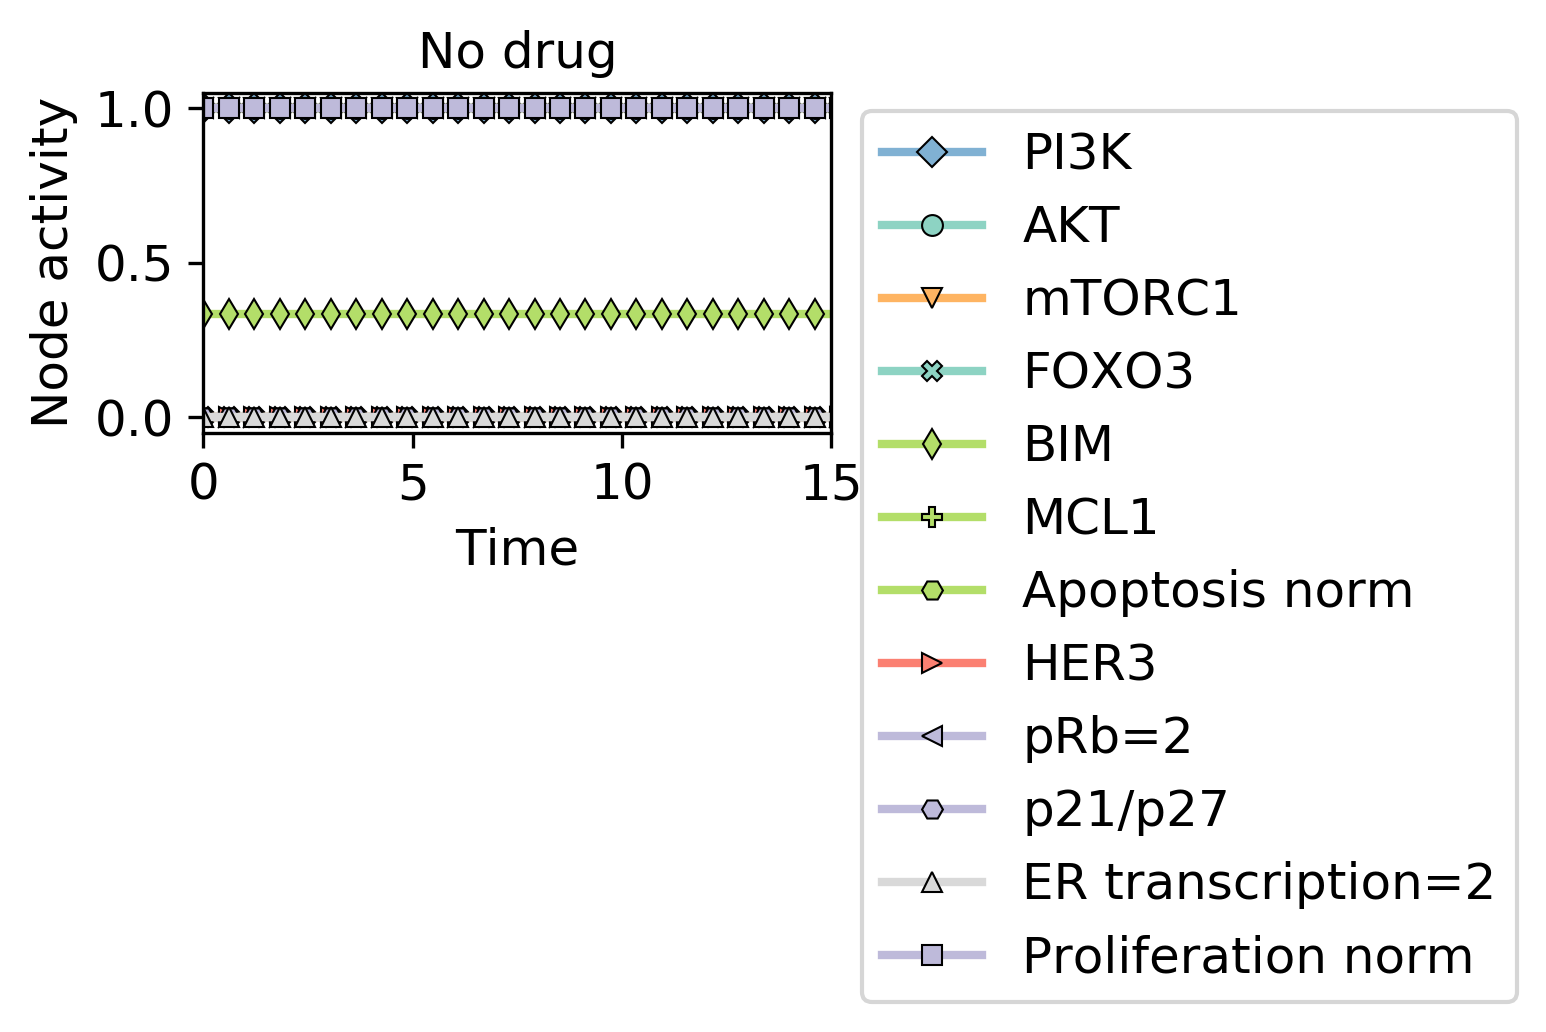

In [16]:
filename='./Figures/BreastCancerModel_ZanudoEtAl2020_MCF7'
df_plot=df_timecourse_alpelisib_0_M.iloc[::3, :]
ax = plt.gca()
df_plot.plot(kind='line',x='time',y='PI3K', marker='D',linestyle='-',c="#80b1d3",markeredgecolor = 'black',ax=ax)
df_plot.plot(kind='line',x='time',y='AKT', marker='o',linestyle='-',c="#8dd3c3",markeredgecolor = 'black',ax=ax)
df_plot.plot(kind='line',x='time',y='mTORC1',marker='v',linestyle='-',color="#feb462",markeredgecolor = 'black',ax=ax)
df_plot.plot(kind='line',x='time',y='FOXO3',marker='X',linestyle='-',c="#8dd3c3",markeredgecolor = 'black',ax=ax)
df_plot.plot(kind='line',x='time',y='BIM',marker='d',linestyle='-',c="#b3de69",markeredgecolor = 'black',ax=ax)
df_plot.plot(kind='line',x='time',y='MCL1',marker='P',linestyle='-',c="#b3de69",markeredgecolor = 'black',ax=ax)
df_plot.plot(kind='line',x='time',y='Apoptosis_norm',marker='H',linestyle='-',c="#b3de69",markeredgecolor = 'black',ax=ax)
df_plot.plot(kind='line',x='time',y='HER3',marker='>',linestyle='-',c="#fb8072ff",markeredgecolor = 'black',ax=ax)
df_plot.plot(kind='line',x='time',y='pRb_2',marker='<',linestyle='-',c="#bebada",markeredgecolor = 'black',ax=ax)
df_plot.plot(kind='line',x='time',y='p21_p27',marker='H',linestyle='-',c="#bebada",markeredgecolor = 'black',ax=ax)
df_plot.plot(kind='line',x='time',y='ER_transcription_2',marker='^',linestyle='-',color="#d9d9d9",markeredgecolor = 'black',ax=ax)
df_plot.plot(kind='line',x='time',y='Proliferation_norm',marker='s',linestyle='-',c="#bebada",markeredgecolor = 'black',ax=ax)
plt.legend(['PI3K','AKT','mTORC1',"FOXO3","BIM","MCL1",'Apoptosis norm',"HER3","pRb=2","p21/p27","ER transcription=2",'Proliferation norm'],bbox_to_anchor=(1.01, 1.02), loc=2, prop={'size':12})
plt.ylabel('Node activity')
plt.xlabel('Time')
plt.title("No drug", fontsize=12)
plt.xlim([0,15])
plt.ylim([-0.05,1.05])
savefig(filename+'.svg', bbox_inches='tight',dpi=450)
savefig(filename+'.png', bbox_inches='tight',dpi=300)
plt.close()
Image(filename=filename+".png")

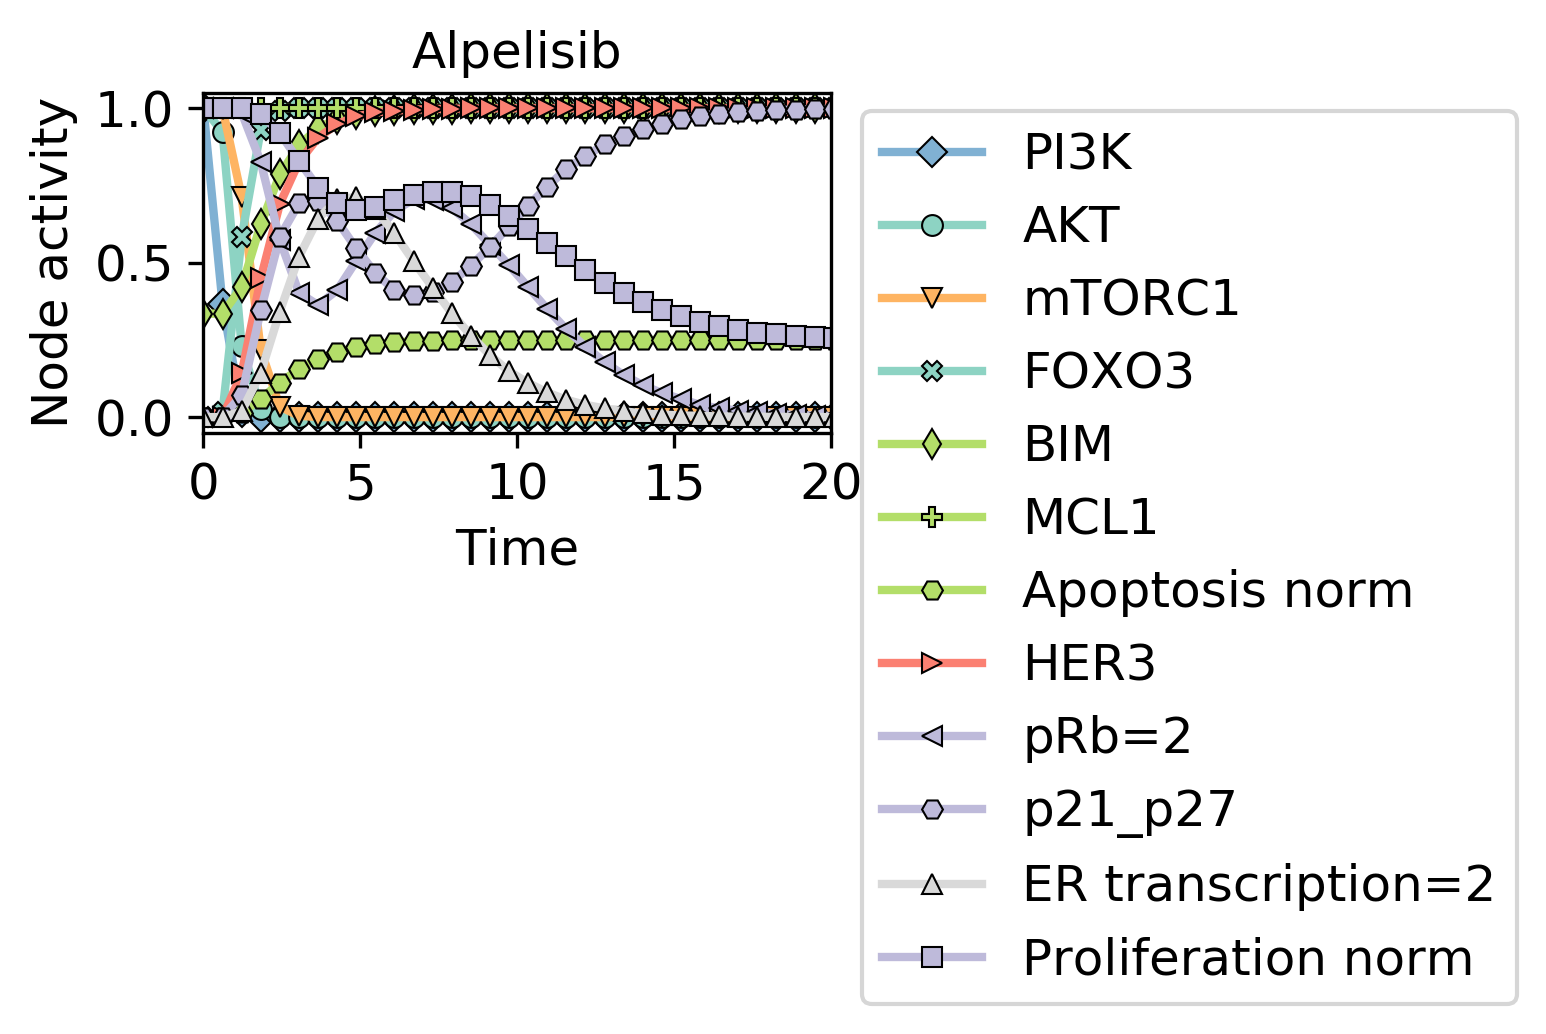

In [17]:
filename='./Figures/BreastCancerModel_ZanudoEtAl2020_MCF7_Alpelisib_1'
df_plot=df_timecourse_alpelisib_1_M.iloc[::3, :]
ax = plt.gca()
df_plot.plot(kind='line',x='time',y='PI3K', marker='D',linestyle='-',c="#80b1d3",markeredgecolor = 'black',ax=ax)
df_plot.plot(kind='line',x='time',y='AKT', marker='o',linestyle='-',c="#8dd3c3",markeredgecolor = 'black',ax=ax)
df_plot.plot(kind='line',x='time',y='mTORC1',marker='v',linestyle='-',color="#feb462",markeredgecolor = 'black',ax=ax)
df_plot.plot(kind='line',x='time',y='FOXO3',marker='X',linestyle='-',c="#8dd3c3",markeredgecolor = 'black',ax=ax)
df_plot.plot(kind='line',x='time',y='BIM',marker='d',linestyle='-',c="#b3de69",markeredgecolor = 'black',ax=ax)
df_plot.plot(kind='line',x='time',y='MCL1',marker='P',linestyle='-',c="#b3de69",markeredgecolor = 'black',ax=ax)
df_plot.plot(kind='line',x='time',y='Apoptosis_norm',marker='H',linestyle='-',c="#b3de69",markeredgecolor = 'black',ax=ax)
df_plot.plot(kind='line',x='time',y='HER3',marker='>',linestyle='-',c="#fb8072ff",markeredgecolor = 'black',ax=ax)
df_plot.plot(kind='line',x='time',y='pRb_2',marker='<',linestyle='-',c="#bebada",markeredgecolor = 'black',ax=ax)
df_plot.plot(kind='line',x='time',y='p21_p27',marker='H',linestyle='-',c="#bebada",markeredgecolor = 'black',ax=ax)
df_plot.plot(kind='line',x='time',y='ER_transcription_2',marker='^',linestyle='-',color="#d9d9d9",markeredgecolor = 'black',ax=ax)
df_plot.plot(kind='line',x='time',y='Proliferation_norm',marker='s',linestyle='-',c="#bebada",markeredgecolor = 'black',ax=ax)
plt.legend(['PI3K','AKT','mTORC1',"FOXO3","BIM","MCL1",'Apoptosis norm',"HER3","pRb=2","p21_p27","ER transcription=2",'Proliferation norm'],bbox_to_anchor=(1.01, 1.02), loc=2, prop={'size':12})
#ax.get_legend().remove()
plt.ylabel('Node activity')
plt.xlabel('Time')
plt.title("Alpelisib", fontsize=12)
plt.xlim([0,20])
plt.ylim([-0.05,1.05])
savefig(filename+'.svg', bbox_inches='tight',dpi=450)
savefig(filename+'.png', bbox_inches='tight',dpi=300)
plt.close()
Image(filename=filename+".png")

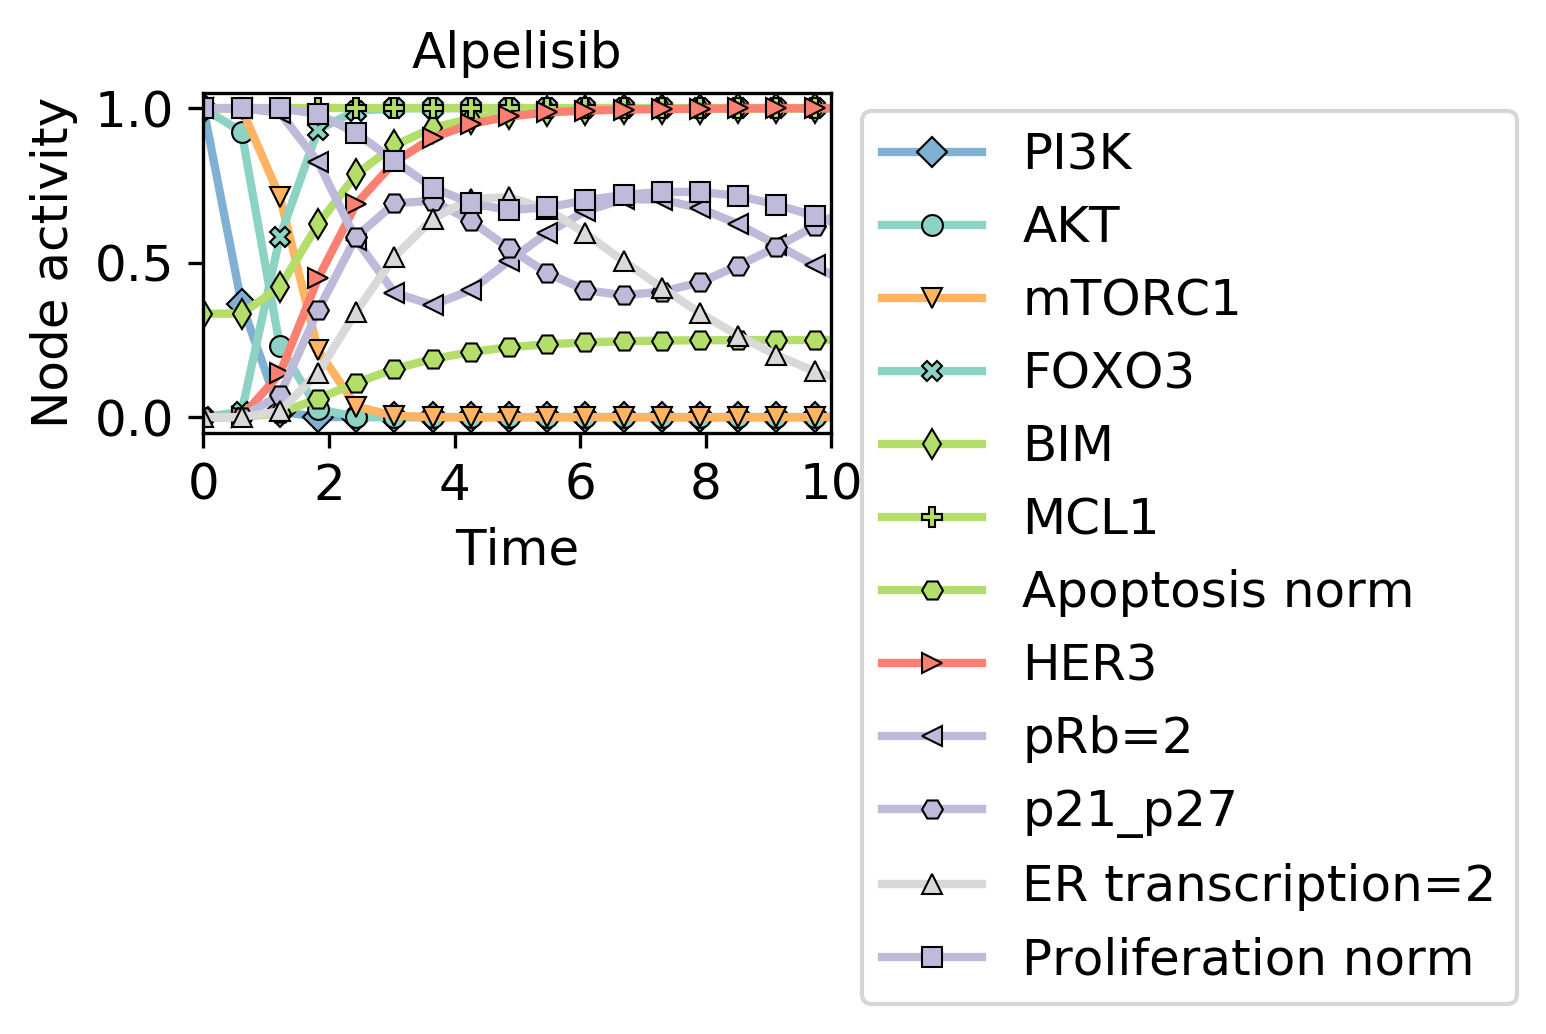

In [18]:
filename='./Figures/BreastCancerModel_ZanudoEtAl2020_MCF7_Alpelisib_1'
df_plot=df_timecourse_alpelisib_1_M.iloc[::3, :]
ax = plt.gca()
df_plot.plot(kind='line',x='time',y='PI3K', marker='D',linestyle='-',c="#80b1d3",markeredgecolor = 'black',ax=ax)
df_plot.plot(kind='line',x='time',y='AKT', marker='o',linestyle='-',c="#8dd3c3",markeredgecolor = 'black',ax=ax)
df_plot.plot(kind='line',x='time',y='mTORC1',marker='v',linestyle='-',color="#feb462",markeredgecolor = 'black',ax=ax)
df_plot.plot(kind='line',x='time',y='FOXO3',marker='X',linestyle='-',c="#8dd3c3",markeredgecolor = 'black',ax=ax)
df_plot.plot(kind='line',x='time',y='BIM',marker='d',linestyle='-',c="#b3de69",markeredgecolor = 'black',ax=ax)
df_plot.plot(kind='line',x='time',y='MCL1',marker='P',linestyle='-',c="#b3de69",markeredgecolor = 'black',ax=ax)
df_plot.plot(kind='line',x='time',y='Apoptosis_norm',marker='H',linestyle='-',c="#b3de69",markeredgecolor = 'black',ax=ax)
df_plot.plot(kind='line',x='time',y='HER3',marker='>',linestyle='-',c="#fb8072ff",markeredgecolor = 'black',ax=ax)
df_plot.plot(kind='line',x='time',y='pRb_2',marker='<',linestyle='-',c="#bebada",markeredgecolor = 'black',ax=ax)
df_plot.plot(kind='line',x='time',y='p21_p27',marker='H',linestyle='-',c="#bebada",markeredgecolor = 'black',ax=ax)
df_plot.plot(kind='line',x='time',y='ER_transcription_2',marker='^',linestyle='-',color="#d9d9d9",markeredgecolor = 'black',ax=ax)
df_plot.plot(kind='line',x='time',y='Proliferation_norm',marker='s',linestyle='-',c="#bebada",markeredgecolor = 'black',ax=ax)
plt.legend(['PI3K','AKT','mTORC1',"FOXO3","BIM","MCL1",'Apoptosis norm',"HER3","pRb=2","p21_p27","ER transcription=2",'Proliferation norm'],bbox_to_anchor=(1.01, 1.02), loc=2, prop={'size':12})
#ax.get_legend().remove()
plt.ylabel('Node activity')
plt.xlabel('Time')
plt.title("Alpelisib", fontsize=12)
xticks([0, 2, 4, 6, 8,10], ['0', '2', '4','6','8','10'])
plt.xlim([0,10])
plt.ylim([-0.05,1.05])
savefig(filename+'_t0-10.svg', bbox_inches='tight',dpi=450)
savefig(filename+'_t0-10.png', bbox_inches='tight',dpi=300)
plt.close()
Image(filename=filename+"_t0-10.png")

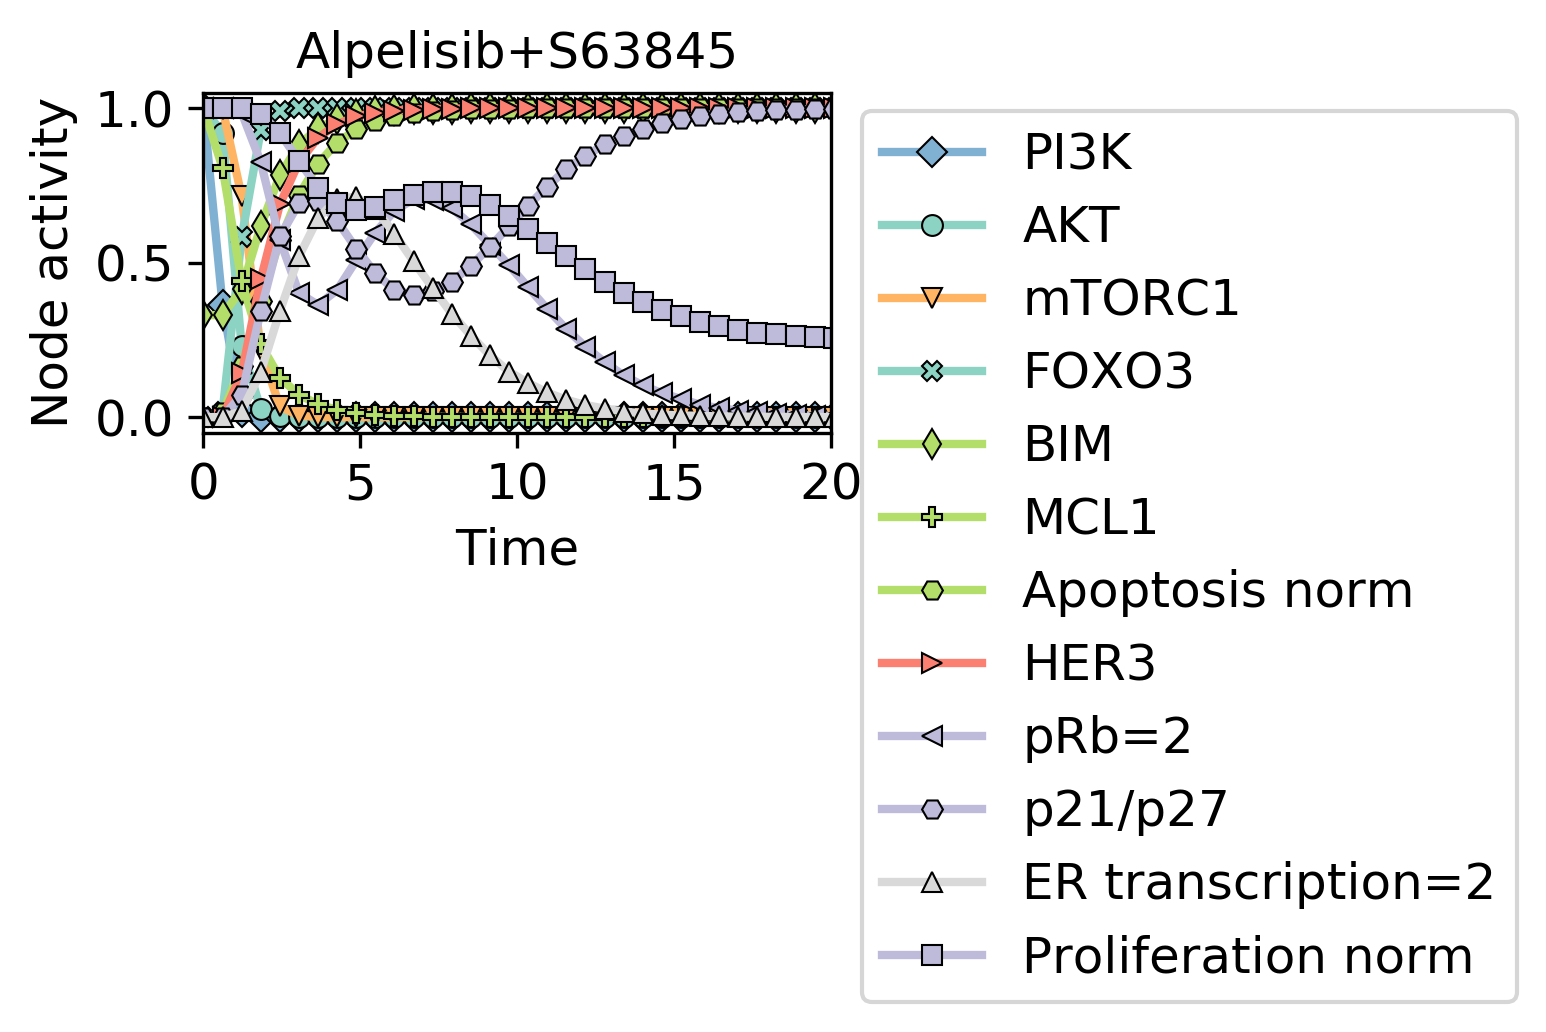

In [19]:
filename='./Figures/BreastCancerModel_ZanudoEtAl2020_MCF7_Alpelisib_S63845_1'
df_plot=df_timecourse_alpelisib_1_S63845_1_M.iloc[::3, :]
ax = plt.gca()
df_plot.plot(kind='line',x='time',y='PI3K', marker='D',linestyle='-',c="#80b1d3",markeredgecolor = 'black',ax=ax)
df_plot.plot(kind='line',x='time',y='AKT', marker='o',linestyle='-',c="#8dd3c3",markeredgecolor = 'black',ax=ax)
df_plot.plot(kind='line',x='time',y='mTORC1',marker='v',linestyle='-',color="#feb462",markeredgecolor = 'black',ax=ax)
df_plot.plot(kind='line',x='time',y='FOXO3',marker='X',linestyle='-',c="#8dd3c3",markeredgecolor = 'black',ax=ax)
df_plot.plot(kind='line',x='time',y='BIM',marker='d',linestyle='-',c="#b3de69",markeredgecolor = 'black',ax=ax)
df_plot.plot(kind='line',x='time',y='MCL1',marker='P',linestyle='-',c="#b3de69",markeredgecolor = 'black',ax=ax)
df_plot.plot(kind='line',x='time',y='Apoptosis_norm',marker='H',linestyle='-',c="#b3de69",markeredgecolor = 'black',ax=ax)
df_plot.plot(kind='line',x='time',y='HER3',marker='>',linestyle='-',c="#fb8072ff",markeredgecolor = 'black',ax=ax)
df_plot.plot(kind='line',x='time',y='pRb_2',marker='<',linestyle='-',c="#bebada",markeredgecolor = 'black',ax=ax)
df_plot.plot(kind='line',x='time',y='p21_p27',marker='H',linestyle='-',c="#bebada",markeredgecolor = 'black',ax=ax)
df_plot.plot(kind='line',x='time',y='ER_transcription_2',marker='^',linestyle='-',color="#d9d9d9",markeredgecolor = 'black',ax=ax)
df_plot.plot(kind='line',x='time',y='Proliferation_norm',marker='s',linestyle='-',c="#bebada",markeredgecolor = 'black',ax=ax)
plt.legend(['PI3K','AKT','mTORC1',"FOXO3","BIM","MCL1",'Apoptosis norm',"HER3","pRb=2","p21/p27","ER transcription=2",'Proliferation norm'],bbox_to_anchor=(1.01, 1.02), loc=2, prop={'size':12})
#ax.get_legend().remove()
plt.ylabel('Node activity')
plt.xlabel('Time')
plt.title("Alpelisib+S63845", fontsize=12)
plt.xlim([0,20])
plt.ylim([-0.05,1.05])
savefig(filename+'.svg', bbox_inches='tight',dpi=450)
savefig(filename+'.png', bbox_inches='tight',dpi=300)
plt.close()
Image(filename=filename+".png")

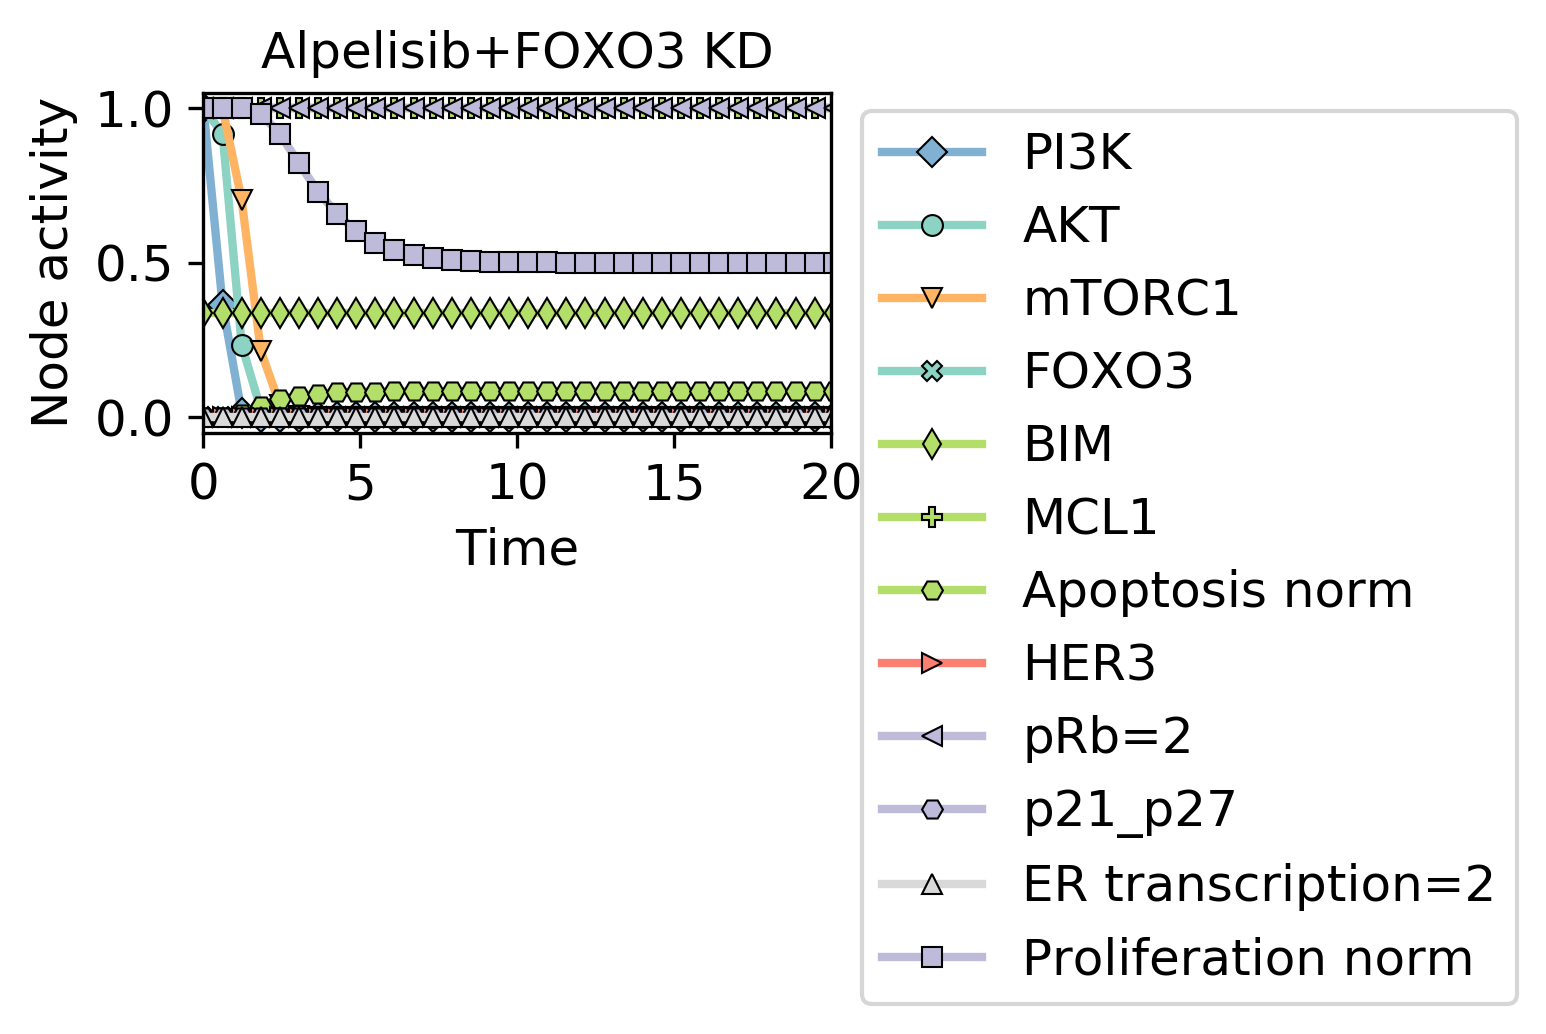

In [20]:
filename='./Figures/BreastCancerModel_ZanudoEtAl2020_MCF7_Alpelisib_FOXO3_0'
df_plot=df_timecourse_alpelisib_1_foxo3_0_M.iloc[::3, :]
ax = plt.gca()
df_plot.plot(kind='line',x='time',y='PI3K', marker='D',linestyle='-',c="#80b1d3",markeredgecolor = 'black',ax=ax)
df_plot.plot(kind='line',x='time',y='AKT', marker='o',linestyle='-',c="#8dd3c3",markeredgecolor = 'black',ax=ax)
df_plot.plot(kind='line',x='time',y='mTORC1',marker='v',linestyle='-',color="#feb462",markeredgecolor = 'black',ax=ax)
df_plot.plot(kind='line',x='time',y='FOXO3',marker='X',linestyle='-',c="#8dd3c3",markeredgecolor = 'black',ax=ax)
df_plot.plot(kind='line',x='time',y='BIM',marker='d',linestyle='-',c="#b3de69",markeredgecolor = 'black',ax=ax)
df_plot.plot(kind='line',x='time',y='MCL1',marker='P',linestyle='-',c="#b3de69",markeredgecolor = 'black',ax=ax)
df_plot.plot(kind='line',x='time',y='Apoptosis_norm',marker='H',linestyle='-',c="#b3de69",markeredgecolor = 'black',ax=ax)
df_plot.plot(kind='line',x='time',y='HER3',marker='>',linestyle='-',c="#fb8072ff",markeredgecolor = 'black',ax=ax)
df_plot.plot(kind='line',x='time',y='pRb_2',marker='<',linestyle='-',c="#bebada",markeredgecolor = 'black',ax=ax)
df_plot.plot(kind='line',x='time',y='p21_p27',marker='H',linestyle='-',c="#bebada",markeredgecolor = 'black',ax=ax)
df_plot.plot(kind='line',x='time',y='ER_transcription_2',marker='^',linestyle='-',color="#d9d9d9",markeredgecolor = 'black',ax=ax)
df_plot.plot(kind='line',x='time',y='Proliferation_norm',marker='s',linestyle='-',c="#bebada",markeredgecolor = 'black',ax=ax)
plt.legend(['PI3K','AKT','mTORC1',"FOXO3","BIM","MCL1",'Apoptosis norm',"HER3","pRb=2","p21_p27","ER transcription=2",'Proliferation norm'],bbox_to_anchor=(1.01, 1.02), loc=2, prop={'size':12})
#ax.get_legend().remove()
plt.ylabel('Node activity')
plt.xlabel('Time')
plt.title("Alpelisib+FOXO3 KD", fontsize=12)
plt.xlim([0,20])
plt.ylim([-0.05,1.05])
savefig(filename+'.svg', bbox_inches='tight',dpi=450)
savefig(filename+'.png', bbox_inches='tight',dpi=300)
plt.close()
Image(filename=filename+".png")

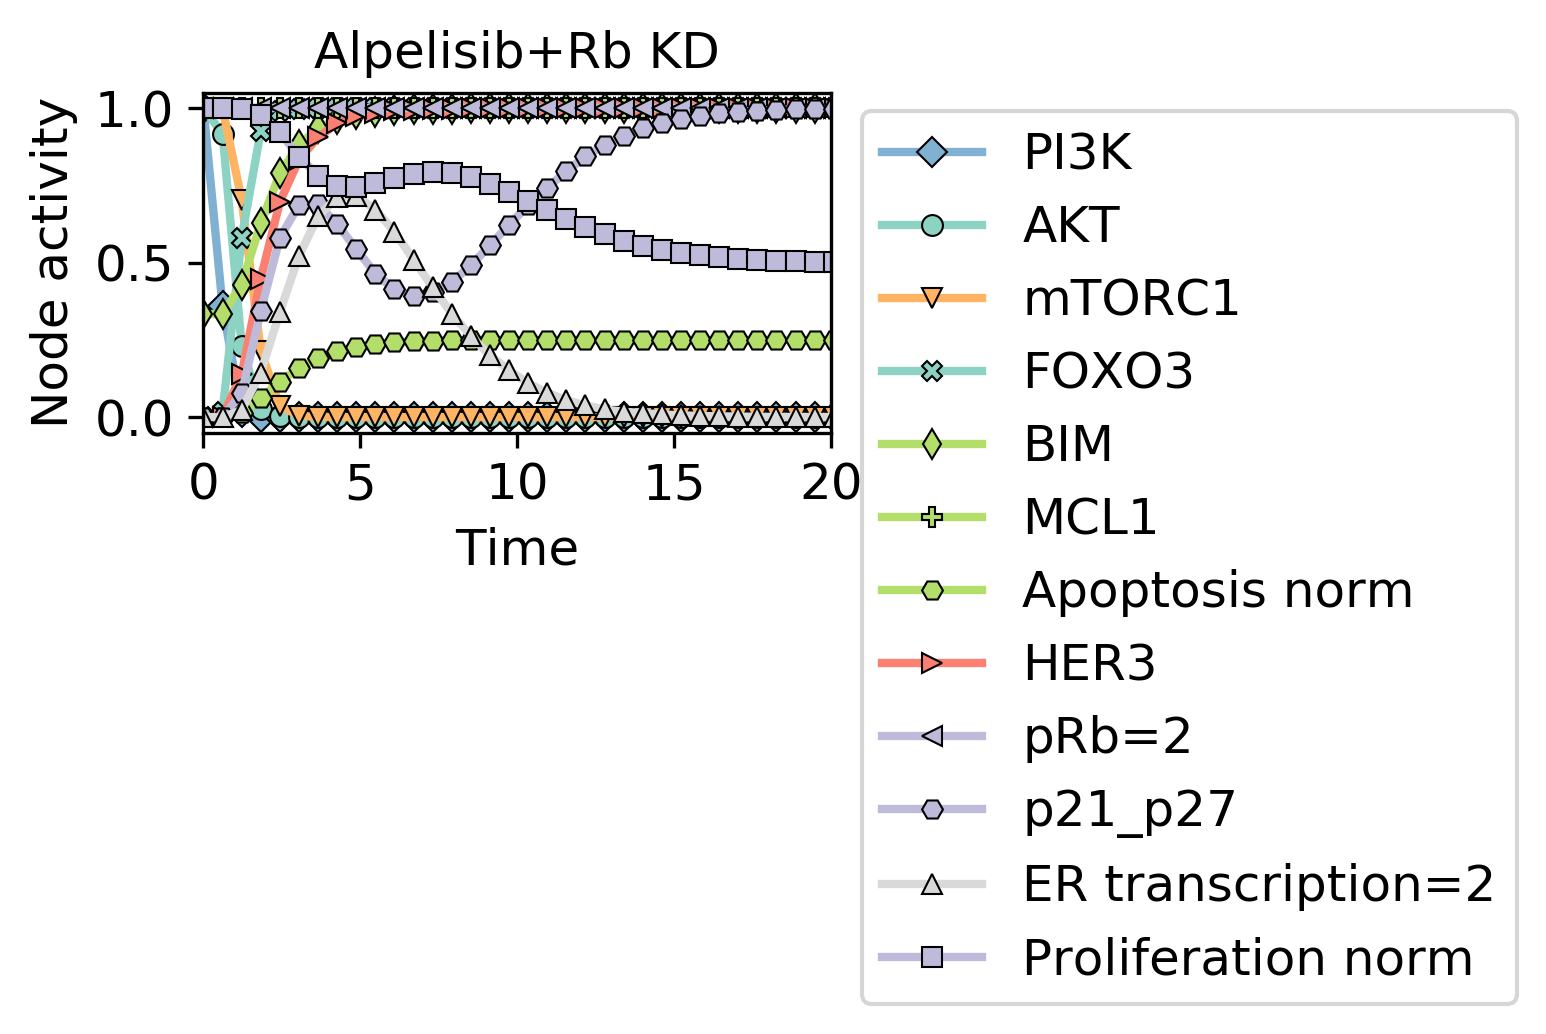

In [21]:
filename='./Figures/BreastCancerModel_ZanudoEtAl2020_MCF7_Alpelisib_RbT_0'
df_plot=df_timecourse_alpelisib_1_RbT_0_M.iloc[::3, :]
ax = plt.gca()
df_plot.plot(kind='line',x='time',y='PI3K', marker='D',linestyle='-',c="#80b1d3",markeredgecolor = 'black',ax=ax)
df_plot.plot(kind='line',x='time',y='AKT', marker='o',linestyle='-',c="#8dd3c3",markeredgecolor = 'black',ax=ax)
df_plot.plot(kind='line',x='time',y='mTORC1',marker='v',linestyle='-',color="#feb462",markeredgecolor = 'black',ax=ax)
df_plot.plot(kind='line',x='time',y='FOXO3',marker='X',linestyle='-',c="#8dd3c3",markeredgecolor = 'black',ax=ax)
df_plot.plot(kind='line',x='time',y='BIM',marker='d',linestyle='-',c="#b3de69",markeredgecolor = 'black',ax=ax)
df_plot.plot(kind='line',x='time',y='MCL1',marker='P',linestyle='-',c="#b3de69",markeredgecolor = 'black',ax=ax)
df_plot.plot(kind='line',x='time',y='Apoptosis_norm',marker='H',linestyle='-',c="#b3de69",markeredgecolor = 'black',ax=ax)
df_plot.plot(kind='line',x='time',y='HER3',marker='>',linestyle='-',c="#fb8072ff",markeredgecolor = 'black',ax=ax)
df_plot.plot(kind='line',x='time',y='pRb_2',marker='<',linestyle='-',c="#bebada",markeredgecolor = 'black',ax=ax)
df_plot.plot(kind='line',x='time',y='p21_p27',marker='H',linestyle='-',c="#bebada",markeredgecolor = 'black',ax=ax)
df_plot.plot(kind='line',x='time',y='ER_transcription_2',marker='^',linestyle='-',color="#d9d9d9",markeredgecolor = 'black',ax=ax)
df_plot.plot(kind='line',x='time',y='Proliferation_norm',marker='s',linestyle='-',c="#bebada",markeredgecolor = 'black',ax=ax)
plt.legend(['PI3K','AKT','mTORC1',"FOXO3","BIM","MCL1",'Apoptosis norm',"HER3","pRb=2","p21_p27","ER transcription=2",'Proliferation norm'],bbox_to_anchor=(1.01, 1.02), loc=2, prop={'size':12})
#ax.get_legend().remove()
plt.ylabel('Node activity')
plt.xlabel('Time')
plt.title("Alpelisib+Rb KD", fontsize=12)
plt.xlim([0,20])
plt.ylim([-0.05,1.05])
savefig(filename+'.svg', bbox_inches='tight',dpi=450)
savefig(filename+'.png', bbox_inches='tight',dpi=300)
plt.close()
Image(filename=filename+".png")

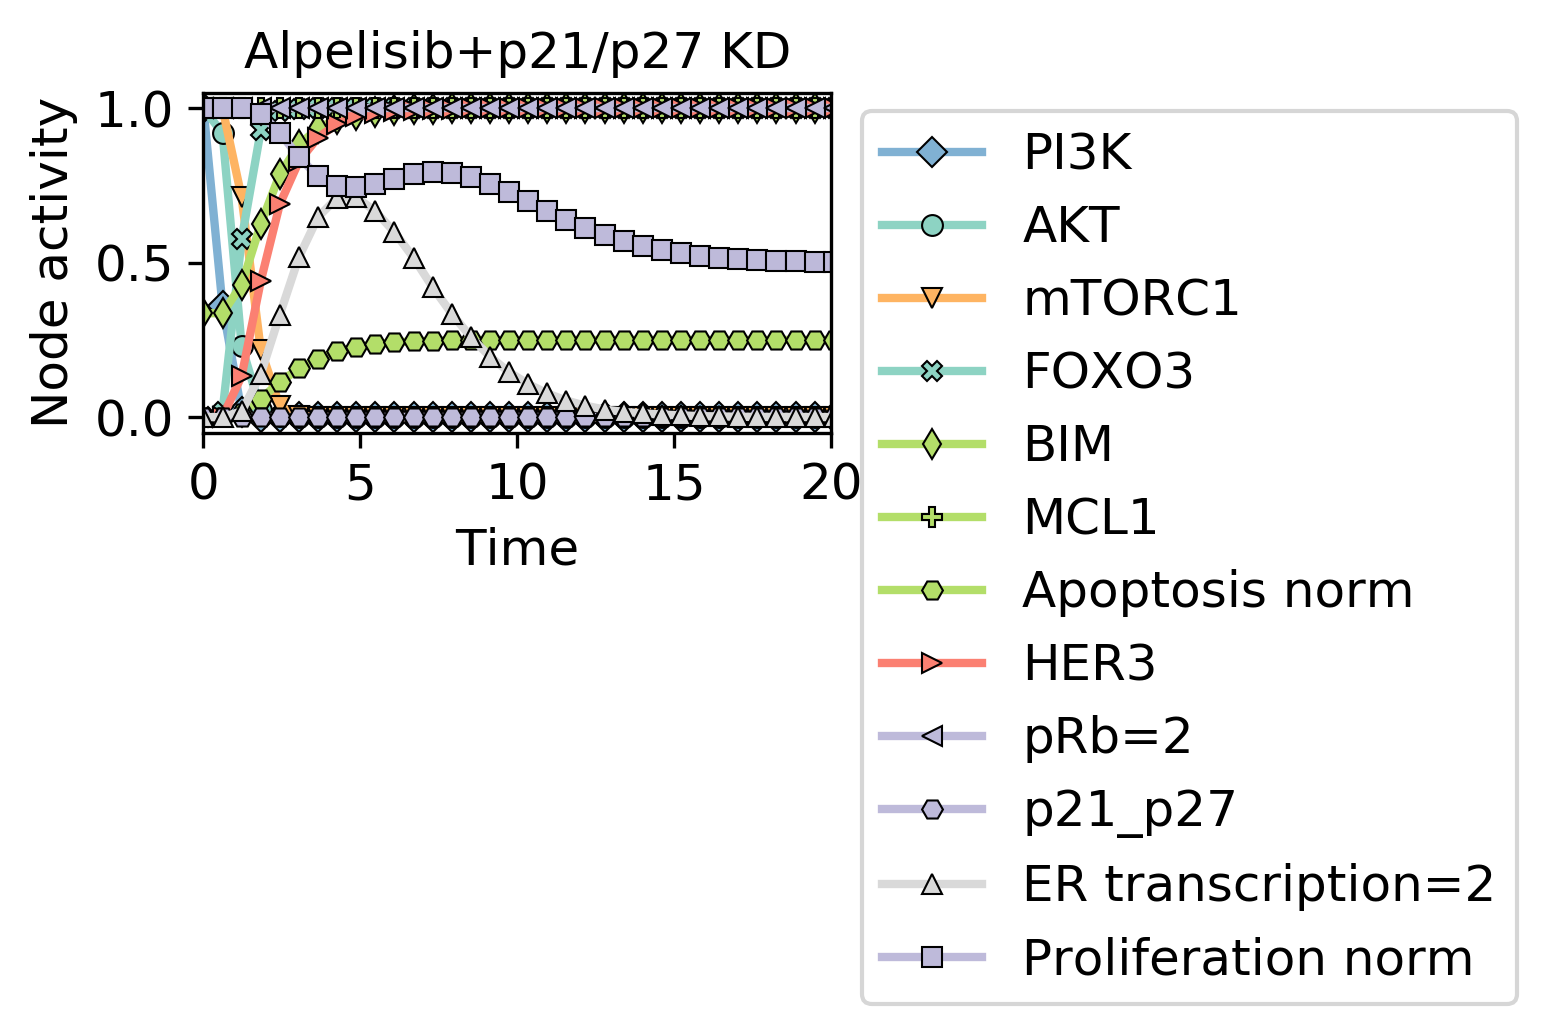

In [22]:
filename='./Figures/BreastCancerModel_ZanudoEtAl2020_MCF7_Alpelisib_p21p27T_0'
df_plot=df_timecourse_alpelisib_1_P21P27T_0_M.iloc[::3, :]
ax = plt.gca()
df_plot.plot(kind='line',x='time',y='PI3K', marker='D',linestyle='-',c="#80b1d3",markeredgecolor = 'black',ax=ax)
df_plot.plot(kind='line',x='time',y='AKT', marker='o',linestyle='-',c="#8dd3c3",markeredgecolor = 'black',ax=ax)
df_plot.plot(kind='line',x='time',y='mTORC1',marker='v',linestyle='-',color="#feb462",markeredgecolor = 'black',ax=ax)
df_plot.plot(kind='line',x='time',y='FOXO3',marker='X',linestyle='-',c="#8dd3c3",markeredgecolor = 'black',ax=ax)
df_plot.plot(kind='line',x='time',y='BIM',marker='d',linestyle='-',c="#b3de69",markeredgecolor = 'black',ax=ax)
df_plot.plot(kind='line',x='time',y='MCL1',marker='P',linestyle='-',c="#b3de69",markeredgecolor = 'black',ax=ax)
df_plot.plot(kind='line',x='time',y='Apoptosis_norm',marker='H',linestyle='-',c="#b3de69",markeredgecolor = 'black',ax=ax)
df_plot.plot(kind='line',x='time',y='HER3',marker='>',linestyle='-',c="#fb8072ff",markeredgecolor = 'black',ax=ax)
df_plot.plot(kind='line',x='time',y='pRb_2',marker='<',linestyle='-',c="#bebada",markeredgecolor = 'black',ax=ax)
df_plot.plot(kind='line',x='time',y='p21_p27',marker='H',linestyle='-',c="#bebada",markeredgecolor = 'black',ax=ax)
df_plot.plot(kind='line',x='time',y='ER_transcription_2',marker='^',linestyle='-',color="#d9d9d9",markeredgecolor = 'black',ax=ax)
df_plot.plot(kind='line',x='time',y='Proliferation_norm',marker='s',linestyle='-',c="#bebada",markeredgecolor = 'black',ax=ax)
plt.legend(['PI3K','AKT','mTORC1',"FOXO3","BIM","MCL1",'Apoptosis norm',"HER3","pRb=2","p21_p27","ER transcription=2",'Proliferation norm'],bbox_to_anchor=(1.01, 1.02), loc=2, prop={'size':12})
#ax.get_legend().remove()
plt.ylabel('Node activity')
plt.xlabel('Time')
plt.title("Alpelisib+p21/p27 KD", fontsize=12)
plt.xlim([0,20])
plt.ylim([-0.05,1.05])
savefig(filename+'.svg', bbox_inches='tight',dpi=450)
savefig(filename+'.png', bbox_inches='tight',dpi=300)
plt.close()
Image(filename=filename+".png")

# Timecourses comparing Alpelisib vs Alpelisib + perturbation in selected perturbations

A particular focus of our model was difference in response to Alpelisib in the presence of the perturbations S63845, FOXO3 knockdown, Rb knockdown, and p21/p27 knockdown. Here we show side by side the timecourse of Alpelisib with or without each of these perturbations.

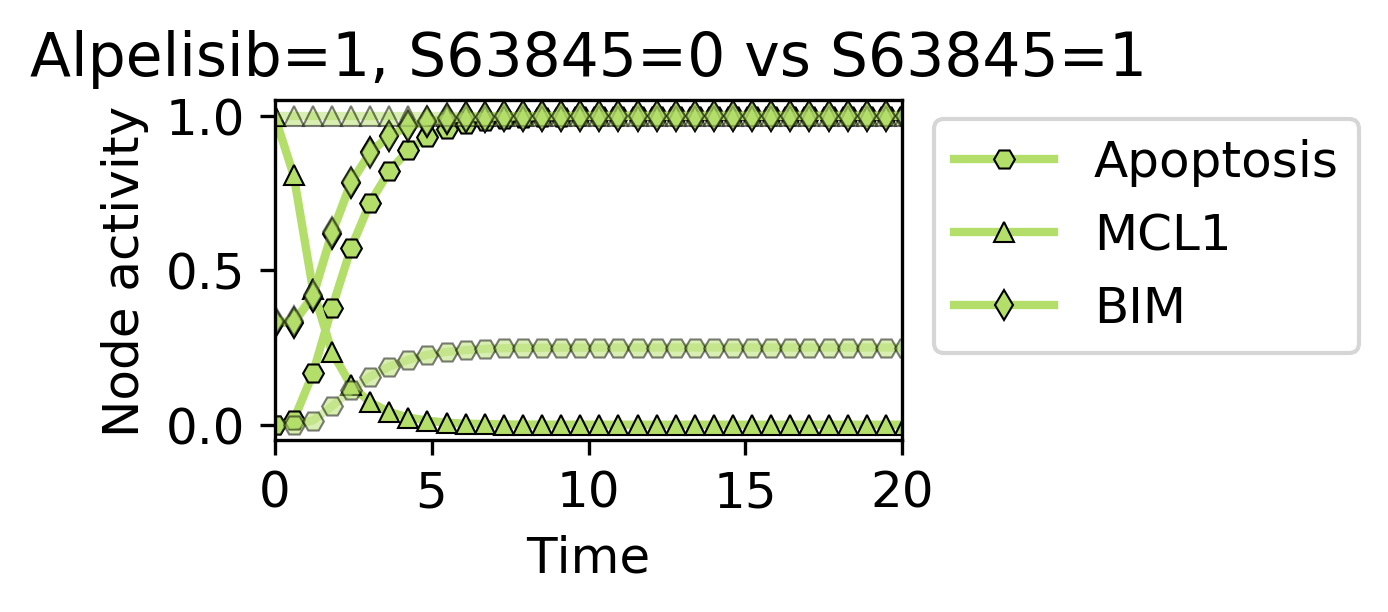

In [23]:
filename='./Figures/BreastCancerModel_ZanudoEtAl2020_MCF7_Alpelisib_1-vs-Alpelisib_1_S63845_1'
df_plot=df_timecourse_alpelisib_1_M.iloc[::3, :]
df_plot2=df_timecourse_alpelisib_1_S63845_1_M.iloc[::3, :]
ax = plt.gca()
df_plot2.plot(kind='line',x='time',y='Apoptosis_norm',marker='H',linestyle='-',c="#b3de69",markeredgecolor = 'black',ax=ax)
df_plot2.plot(kind='line',x='time',y='MCL1',marker='^',linestyle='-',c="#b3de69",markeredgecolor = 'black',ax=ax)
df_plot2.plot(kind='line',x='time',y='BIM',marker='d',linestyle='-',c="#b3de69",markeredgecolor = 'black',ax=ax)
df_plot.plot(kind='line',x='time',y='Apoptosis_norm',marker='H',linestyle='-',c="#b3de69",markeredgecolor = 'black',alpha=0.5,ax=ax)
df_plot.plot(kind='line',x='time',y='MCL1',marker='^',linestyle='-',c="#b3de69",markeredgecolor = 'black',alpha=0.5,ax=ax)
df_plot.plot(kind='line',x='time',y='BIM',marker='d',linestyle='-',c="#b3de69",markeredgecolor = 'black',alpha=0.5,ax=ax)
plt.legend(['Apoptosis',"MCL1","BIM"],bbox_to_anchor=(1.01, 1.02), loc=2, prop={'size':12})
plt.ylabel('Node activity')
plt.xlabel('Time')
plt.title("Alpelisib=1, S63845=0 vs S63845=1")
plt.xlim([0,20])
plt.ylim([-0.05,1.05])
savefig(filename+'.svg', bbox_inches='tight',dpi=450)
savefig(filename+'.png', bbox_inches='tight',dpi=300)
plt.close()
Image(filename=filename+".png") 

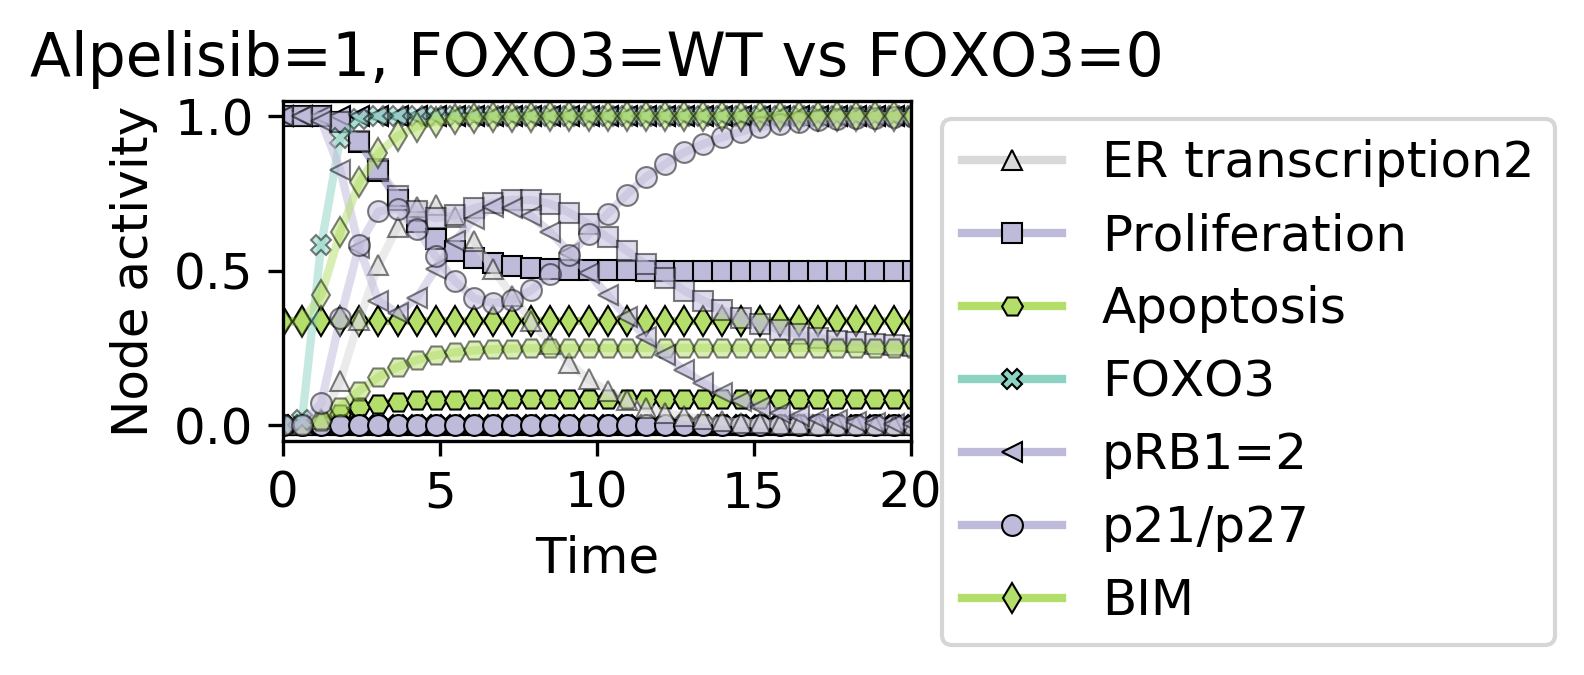

In [24]:
filename='./Figures/BreastCancerModel_ZanudoEtAl2020_MCF7_Alpelisib_1-vs-Alpelisib_1_FOXO3_0'
df_plot=df_timecourse_alpelisib_1_M.iloc[::3, :]
df_plot2=df_timecourse_alpelisib_1_foxo3_0_M.iloc[::3, :]
ax = plt.gca()
df_plot2.plot(kind='line',x='time',y='ER_transcription_2',marker='^',linestyle='-',color="#d9d9d9",markeredgecolor = 'black',ax=ax)
df_plot2.plot(kind='line',x='time',y='Proliferation_norm',marker='s',linestyle='-',c="#bebada",markeredgecolor = 'black',ax=ax)
df_plot2.plot(kind='line',x='time',y='Apoptosis_norm',marker='H',linestyle='-',c="#b3de69",markeredgecolor = 'black',ax=ax)
df_plot2.plot(kind='line',x='time',y='FOXO3',marker='X',linestyle='-',c="#8dd3c3",markeredgecolor = 'black',ax=ax)
df_plot2.plot(kind='line',x='time',y='pRb_2',marker='<',linestyle='-',c="#bebada",markeredgecolor = 'black',ax=ax)
df_plot2.plot(kind='line',x='time',y='p21_p27',marker='o',linestyle='-',c="#bebada",markeredgecolor = 'black',ax=ax)
df_plot2.plot(kind='line',x='time',y='BIM',marker='d',linestyle='-',c="#b3de69",markeredgecolor = 'black',ax=ax)
df_plot.plot(kind='line',x='time',y='ER_transcription_2',marker='^',linestyle='-',color="#d9d9d9",markeredgecolor = 'black',alpha=0.5,ax=ax)
df_plot.plot(kind='line',x='time',y='Proliferation_norm',marker='s',linestyle='-',c="#bebada",markeredgecolor = 'black',alpha=0.5,ax=ax)
df_plot.plot(kind='line',x='time',y='Apoptosis_norm',marker='H',linestyle='-',c="#b3de69",markeredgecolor = 'black',alpha=0.5,ax=ax)
df_plot.plot(kind='line',x='time',y='FOXO3',marker='X',linestyle='-',c="#8dd3c3",markeredgecolor = 'black',alpha=0.5,ax=ax)
df_plot.plot(kind='line',x='time',y='pRb_2',marker='<',linestyle='-',c="#bebada",markeredgecolor = 'black',alpha=0.5,ax=ax)
df_plot.plot(kind='line',x='time',y='p21_p27',marker='o',linestyle='-',c="#bebada",markeredgecolor = 'black',alpha=0.5,ax=ax)
df_plot.plot(kind='line',x='time',y='BIM',marker='d',linestyle='-',c="#b3de69",markeredgecolor = 'black',alpha=0.5,ax=ax)
plt.legend(["ER transcription2",'Proliferation','Apoptosis',"FOXO3","pRB1=2","p21/p27","BIM"],bbox_to_anchor=(1.01, 1.02), loc=2, prop={'size':12})
plt.ylabel('Node activity')
plt.xlabel('Time')
plt.title("Alpelisib=1, FOXO3=WT vs FOXO3=0")
plt.xlim([0,20])
plt.ylim([-0.05,1.05])
savefig(filename+'.svg', bbox_inches='tight',dpi=450)
savefig(filename+'.png', bbox_inches='tight',dpi=300)
plt.close()
Image(filename=filename+".png") 

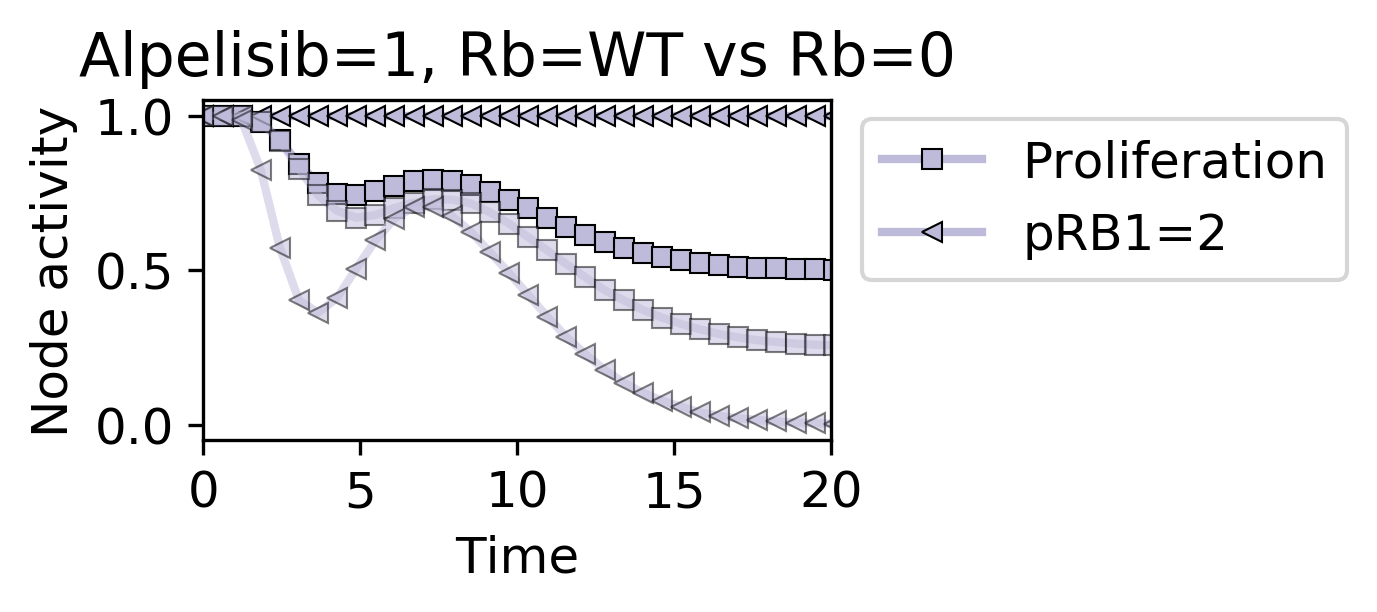

In [25]:
filename='./Figures/BreastCancerModel_ZanudoEtAl2020_MCF7_Alpelisib_1-vs-Alpelisib_1_RbT_0'
df_plot=df_timecourse_alpelisib_1_M.iloc[::3, :]
df_plot2=df_timecourse_alpelisib_1_RbT_0_M.iloc[::3, :]
ax = plt.gca()
df_plot2.plot(kind='line',x='time',y='Proliferation_norm',marker='s',linestyle='-',c="#bebada",markeredgecolor = 'black',ax=ax)
df_plot2.plot(kind='line',x='time',y='pRb_2',marker='<',linestyle='-',c="#bebada",markeredgecolor = 'black',ax=ax)
df_plot.plot(kind='line',x='time',y='Proliferation_norm',marker='s',linestyle='-',c="#bebada",markeredgecolor = 'black',alpha=0.5,ax=ax)
df_plot.plot(kind='line',x='time',y='pRb_2',marker='<',linestyle='-',c="#bebada",markeredgecolor = 'black',alpha=0.5,ax=ax)
plt.legend(['Proliferation',"pRB1=2"],bbox_to_anchor=(1.01, 1.02), loc=2, prop={'size':12})
plt.ylabel('Node activity')
plt.xlabel('Time')
plt.title("Alpelisib=1, Rb=WT vs Rb=0")
plt.xlim([0,20])
plt.ylim([-0.05,1.05])
savefig(filename+'.svg', bbox_inches='tight',dpi=450)
savefig(filename+'.png', bbox_inches='tight',dpi=300)
plt.close()
Image(filename=filename+".png") 

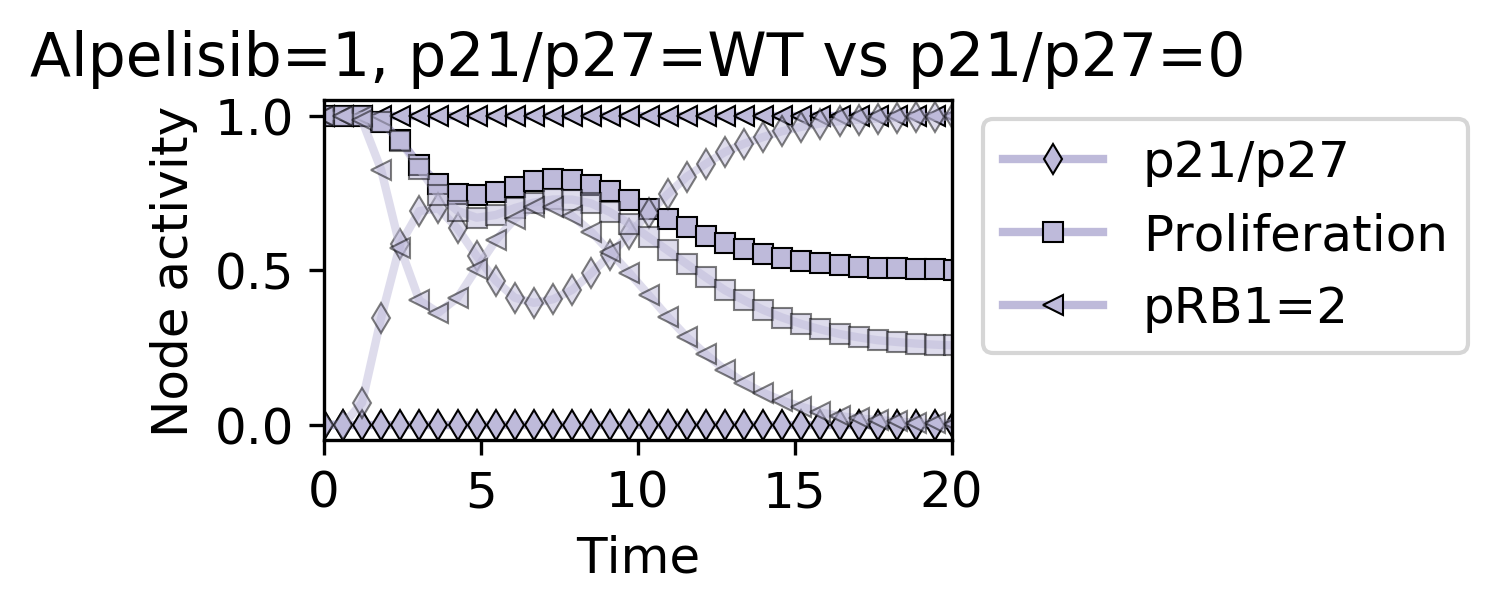

In [26]:
filename='./Figures/BreastCancerModel_ZanudoEtAl2020_MCF7_Alpelisib_1-vs-Alpelisib_1_p21p27T_0'
df_plot=df_timecourse_alpelisib_1_M.iloc[::3, :]
df_plot2=df_timecourse_alpelisib_1_P21P27T_0_M.iloc[::3, :]
ax = plt.gca()
df_plot2.plot(kind='line',x='time',y='p21_p27',marker='d',linestyle='-',c="#bebada",markeredgecolor = 'black',ax=ax)
df_plot2.plot(kind='line',x='time',y='Proliferation_norm',marker='s',linestyle='-',c="#bebada",markeredgecolor = 'black',ax=ax)
df_plot2.plot(kind='line',x='time',y='pRb_2',marker='<',linestyle='-',c="#bebada",markeredgecolor = 'black',ax=ax)
df_plot.plot(kind='line',x='time',y='p21_p27',marker='d',linestyle='-',c="#bebada",markeredgecolor = 'black',alpha=0.5,ax=ax)
df_plot.plot(kind='line',x='time',y='Proliferation_norm',marker='s',linestyle='-',c="#bebada",markeredgecolor = 'black',alpha=0.5,ax=ax)
df_plot.plot(kind='line',x='time',y='pRb_2',marker='<',linestyle='-',c="#bebada",markeredgecolor = 'black',alpha=0.5,ax=ax)
plt.legend(['p21/p27','Proliferation',"pRB1=2"],bbox_to_anchor=(1.01, 1.02), loc=2, prop={'size':12})
plt.ylabel('Node activity')
plt.xlabel('Time')
plt.title("Alpelisib=1, p21/p27=WT vs p21/p27=0")
plt.xlim([0,20])
plt.ylim([-0.05,1.05])
savefig(filename+'.svg', bbox_inches='tight',dpi=450)
savefig(filename+'.png', bbox_inches='tight',dpi=300)
plt.close()
Image(filename=filename+".png") 

# Timecourses of original model

Here we illustrate how we can simulate the Zanudo et al. 2017 model. This follows the same approach as in the Zanudo et. al 2020 model above.

In [27]:
jar_path="../dist/BreastCancerModel.jar"
filename="../Models/BreastCancerModel_ZanudoEtAl2017.booleannet"
initial_conditions=10000
normalized_time_steps=25
write_timecourse="true"

In [28]:
generate_BCmodel(filename,jar_path)


Filename: ../Models/BreastCancerModel_ZanudoEtAl2017.booleannet
Creating Boolean table directory: BreastCancerModel_ZanudoEtAl2017
Boolean table directory created.
Functions and names files created.
Creating network model...
Model created.
Exiting program


In [29]:
parameters=get_parameters(filename,initial_conditions,normalized_time_steps,write_timecourse)
run_BCmodel(parameters, jar_path,quiet=False)


Filename: ../Models/BreastCancerModel_ZanudoEtAl2017.booleannet
Creating network model based on Boolean tables, functions, and names files...
Model created.
Perturbation	Apofrac1	Apofrac2	Apofrac3	Apofrac	Prolfrac1	Prolfrac2	Prolfrac3	Prolfrac4	Prolfrac
No Perturbation	0.0	0.0	0.0	0.0	1.0	1.0	1.0	0.0	0.5


In [30]:
perturbation_nodes=["Alpelisib"]
perturbation_states=["1"]
parameters=get_parameters(filename,initial_conditions,normalized_time_steps,write_timecourse,perturbation_nodes,perturbation_states)
run_BCmodel(parameters, jar_path,quiet=False)


Filename: ../Models/BreastCancerModel_ZanudoEtAl2017.booleannet
Creating network model based on Boolean tables, functions, and names files...
Model created.
Perturbation	Apofrac1	Apofrac2	Apofrac3	Apofrac	Prolfrac1	Prolfrac2	Prolfrac3	Prolfrac4	Prolfrac
Alpelisib=1	1.0	1.0	0.4	0.7	1.0	1.0	0.0	0.0	0.25


In [31]:
import shutil

source = './'
dest1 = './timecourses'

files = os.listdir(source)

for f in files:
    bnfile=os.path.basename(f)
    if bnfile.startswith("timecourseBreastCancerModel"):
        #print(bnfile)
        shutil.copy(source+f, dest1)
        os.remove(source+f)
    if bnfile.startswith("timecourseSEMBreastCancerModel"):
        #print(bnfile)
        shutil.copy(source+f, dest1)
        os.remove(source+f)

In [32]:
basename=os.path.basename(filename).split(".")[0]

perturbation_nodes=[]
perturbation_states=[]
df_timecourse=read_in_timecourse(basename,perturbation_nodes,perturbation_states)
df_timecourse_alpelisib_0=df_timecourse.T

perturbation_nodes=["Alpelisib"]
perturbation_states=["1"]
df_timecourse=read_in_timecourse(basename,perturbation_nodes,perturbation_states)
df_timecourse_alpelisib_1=df_timecourse.T

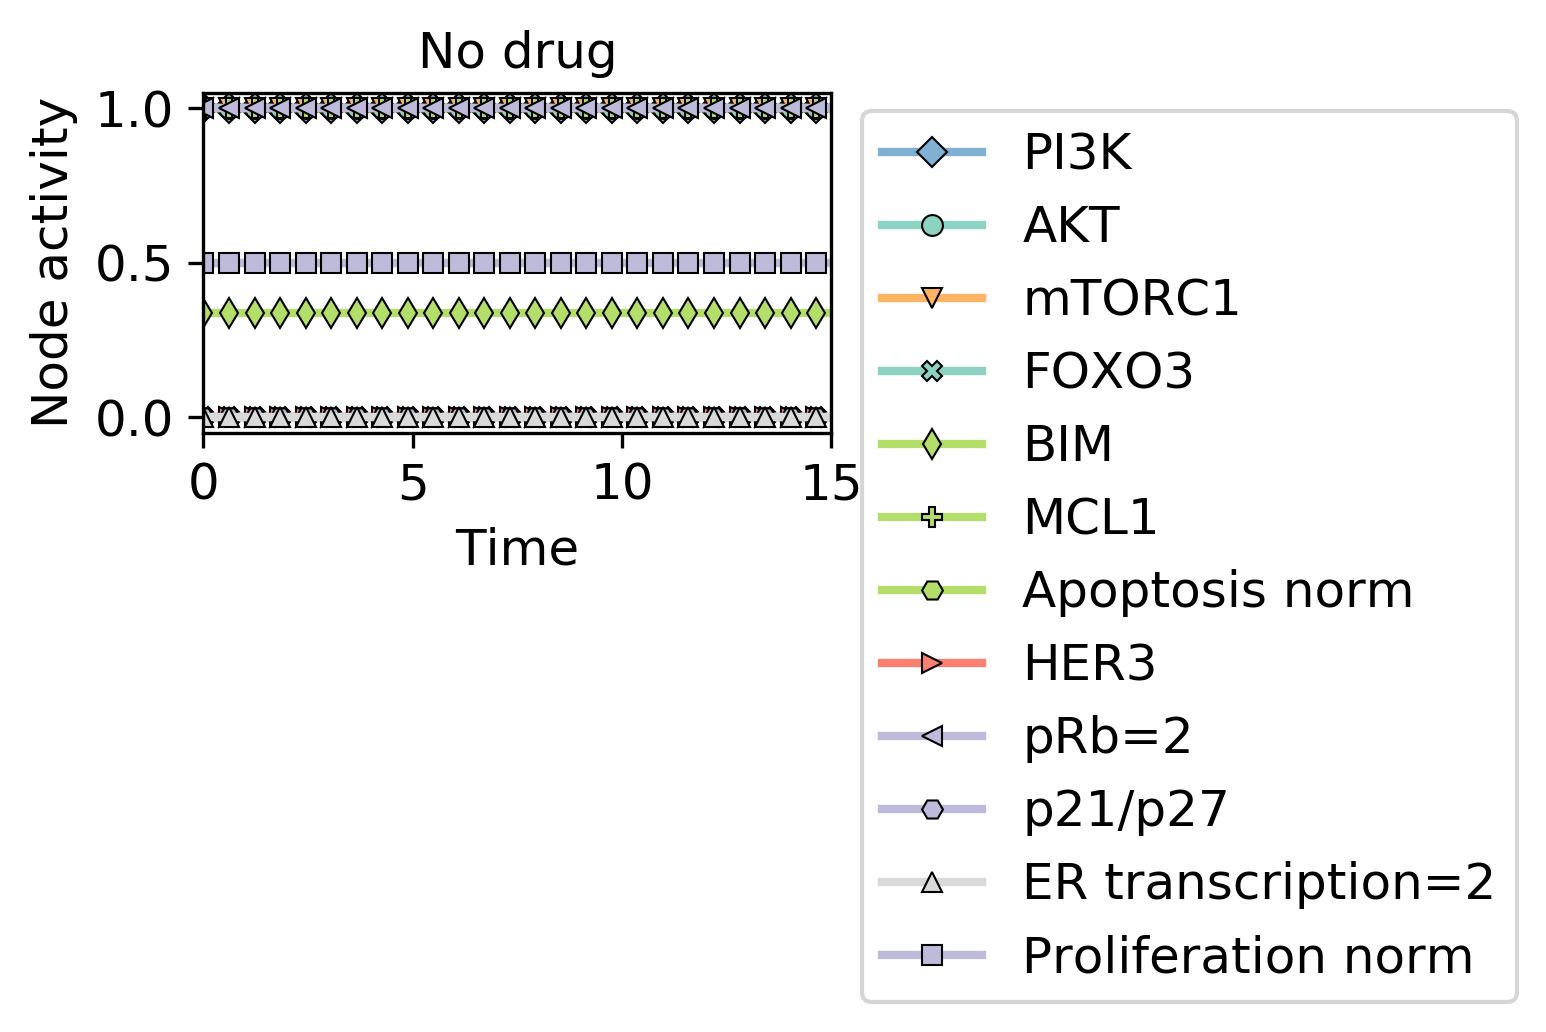

In [33]:
filename='figures/BreastCancerModel_ZanudoEtAl2017'
df_plot=df_timecourse_alpelisib_0.iloc[::3, :]
ax = plt.gca()
df_plot.plot(kind='line',x='time',y='PI3K', marker='D',linestyle='-',c="#80b1d3",markeredgecolor = 'black',ax=ax)
df_plot.plot(kind='line',x='time',y='AKT', marker='o',linestyle='-',c="#8dd3c3",markeredgecolor = 'black',ax=ax)
df_plot.plot(kind='line',x='time',y='mTORC1',marker='v',linestyle='-',color="#feb462",markeredgecolor = 'black',ax=ax)
df_plot.plot(kind='line',x='time',y='FOXO3',marker='X',linestyle='-',c="#8dd3c3",markeredgecolor = 'black',ax=ax)
df_plot.plot(kind='line',x='time',y='BIM',marker='d',linestyle='-',c="#b3de69",markeredgecolor = 'black',ax=ax)
df_plot.plot(kind='line',x='time',y='MCL1',marker='P',linestyle='-',c="#b3de69",markeredgecolor = 'black',ax=ax)
df_plot.plot(kind='line',x='time',y='Apoptosis_norm',marker='H',linestyle='-',c="#b3de69",markeredgecolor = 'black',ax=ax)
df_plot.plot(kind='line',x='time',y='HER3',marker='>',linestyle='-',c="#fb8072ff",markeredgecolor = 'black',ax=ax)
df_plot.plot(kind='line',x='time',y='pRb_2',marker='<',linestyle='-',c="#bebada",markeredgecolor = 'black',ax=ax)
df_plot.plot(kind='line',x='time',y='p21_p27',marker='H',linestyle='-',c="#bebada",markeredgecolor = 'black',ax=ax)
df_plot.plot(kind='line',x='time',y='ER_transcription_2',marker='^',linestyle='-',color="#d9d9d9",markeredgecolor = 'black',ax=ax)
df_plot.plot(kind='line',x='time',y='Proliferation_norm',marker='s',linestyle='-',c="#bebada",markeredgecolor = 'black',ax=ax)
plt.legend(['PI3K','AKT','mTORC1',"FOXO3","BIM","MCL1",'Apoptosis norm',"HER3","pRb=2","p21/p27","ER transcription=2",'Proliferation norm'],bbox_to_anchor=(1.01, 1.02), loc=2, prop={'size':12})
plt.ylabel('Node activity')
plt.xlabel('Time')
plt.title("No drug", fontsize=12)
plt.xlim([0,15])
plt.ylim([-0.05,1.05])
savefig(filename+'.svg', bbox_inches='tight',dpi=450)
savefig(filename+'.png', bbox_inches='tight',dpi=300)
plt.close()
Image(filename=filename+".png")

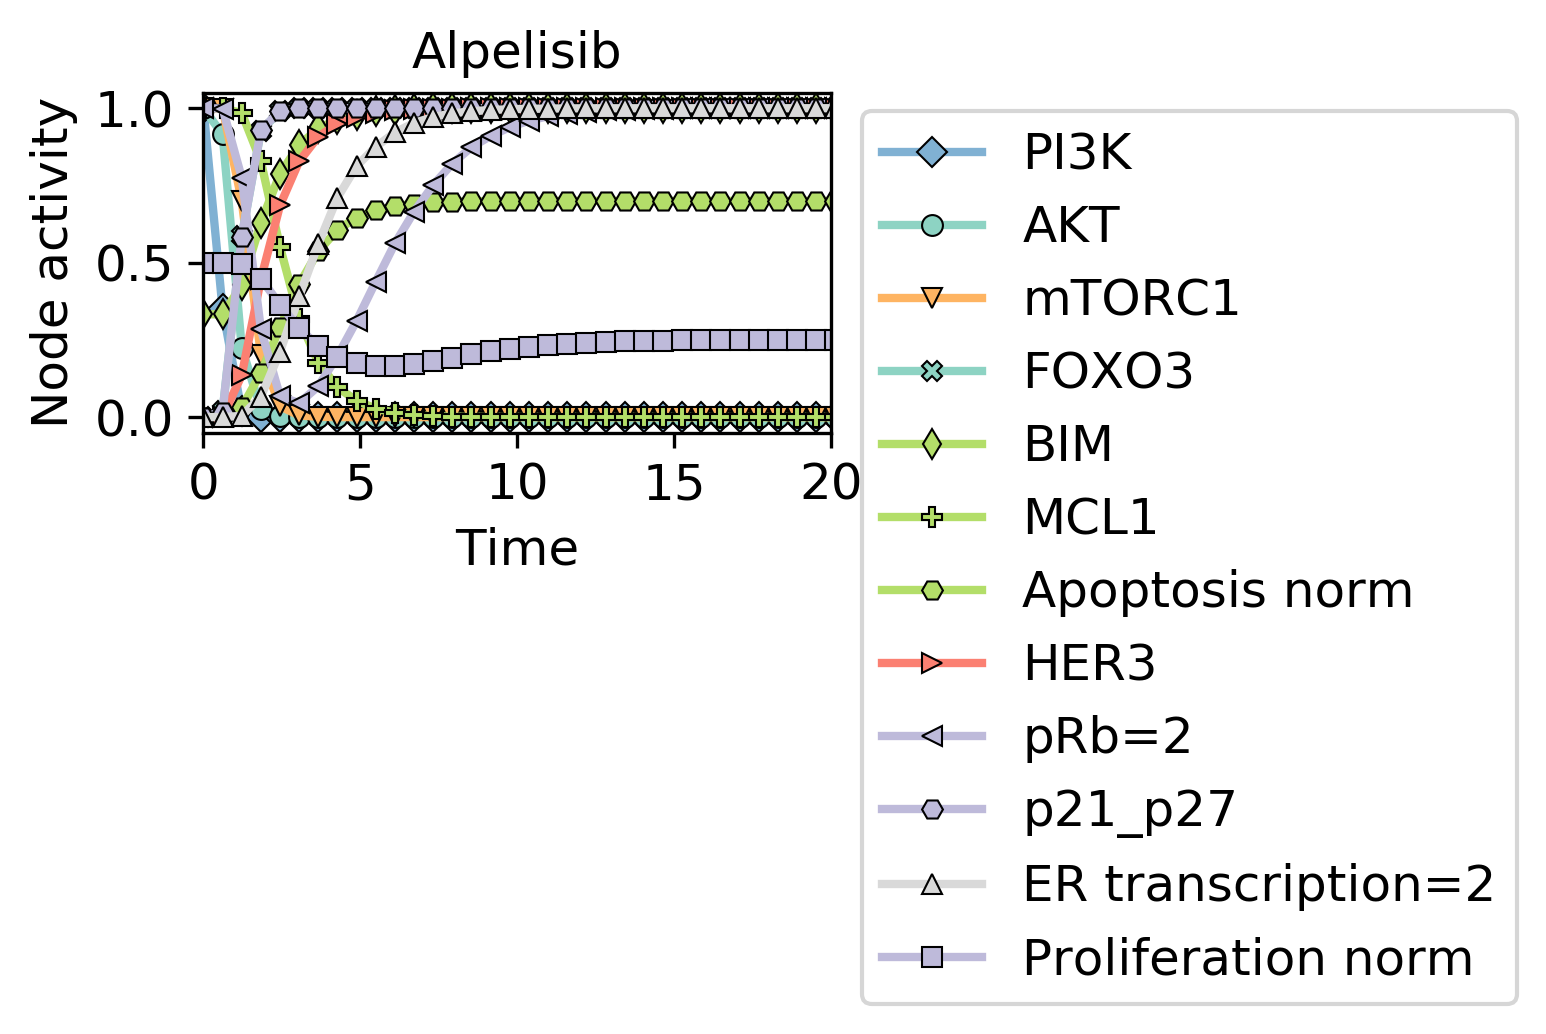

In [34]:
filename='figures/BreastCancerModel_ZanudoEtAl2017_Alpelisib_1'
df_plot=df_timecourse_alpelisib_1.iloc[::3, :]
ax = plt.gca()
df_plot.plot(kind='line',x='time',y='PI3K', marker='D',linestyle='-',c="#80b1d3",markeredgecolor = 'black',ax=ax)
df_plot.plot(kind='line',x='time',y='AKT', marker='o',linestyle='-',c="#8dd3c3",markeredgecolor = 'black',ax=ax)
df_plot.plot(kind='line',x='time',y='mTORC1',marker='v',linestyle='-',color="#feb462",markeredgecolor = 'black',ax=ax)
df_plot.plot(kind='line',x='time',y='FOXO3',marker='X',linestyle='-',c="#8dd3c3",markeredgecolor = 'black',ax=ax)
df_plot.plot(kind='line',x='time',y='BIM',marker='d',linestyle='-',c="#b3de69",markeredgecolor = 'black',ax=ax)
df_plot.plot(kind='line',x='time',y='MCL1',marker='P',linestyle='-',c="#b3de69",markeredgecolor = 'black',ax=ax)
df_plot.plot(kind='line',x='time',y='Apoptosis_norm',marker='H',linestyle='-',c="#b3de69",markeredgecolor = 'black',ax=ax)
df_plot.plot(kind='line',x='time',y='HER3',marker='>',linestyle='-',c="#fb8072ff",markeredgecolor = 'black',ax=ax)
df_plot.plot(kind='line',x='time',y='pRb_2',marker='<',linestyle='-',c="#bebada",markeredgecolor = 'black',ax=ax)
df_plot.plot(kind='line',x='time',y='p21_p27',marker='H',linestyle='-',c="#bebada",markeredgecolor = 'black',ax=ax)
df_plot.plot(kind='line',x='time',y='ER_transcription_2',marker='^',linestyle='-',color="#d9d9d9",markeredgecolor = 'black',ax=ax)
df_plot.plot(kind='line',x='time',y='Proliferation_norm',marker='s',linestyle='-',c="#bebada",markeredgecolor = 'black',ax=ax)
plt.legend(['PI3K','AKT','mTORC1',"FOXO3","BIM","MCL1",'Apoptosis norm',"HER3","pRb=2","p21_p27","ER transcription=2",'Proliferation norm'],bbox_to_anchor=(1.01, 1.02), loc=2, prop={'size':12})
#ax.get_legend().remove()
plt.ylabel('Node activity')
plt.xlabel('Time')
plt.title("Alpelisib", fontsize=12)
plt.xlim([0,20])
plt.ylim([-0.05,1.05])
savefig(filename+'.svg', bbox_inches='tight',dpi=450)
savefig(filename+'.png', bbox_inches='tight',dpi=300)
plt.close()
Image(filename=filename+".png")

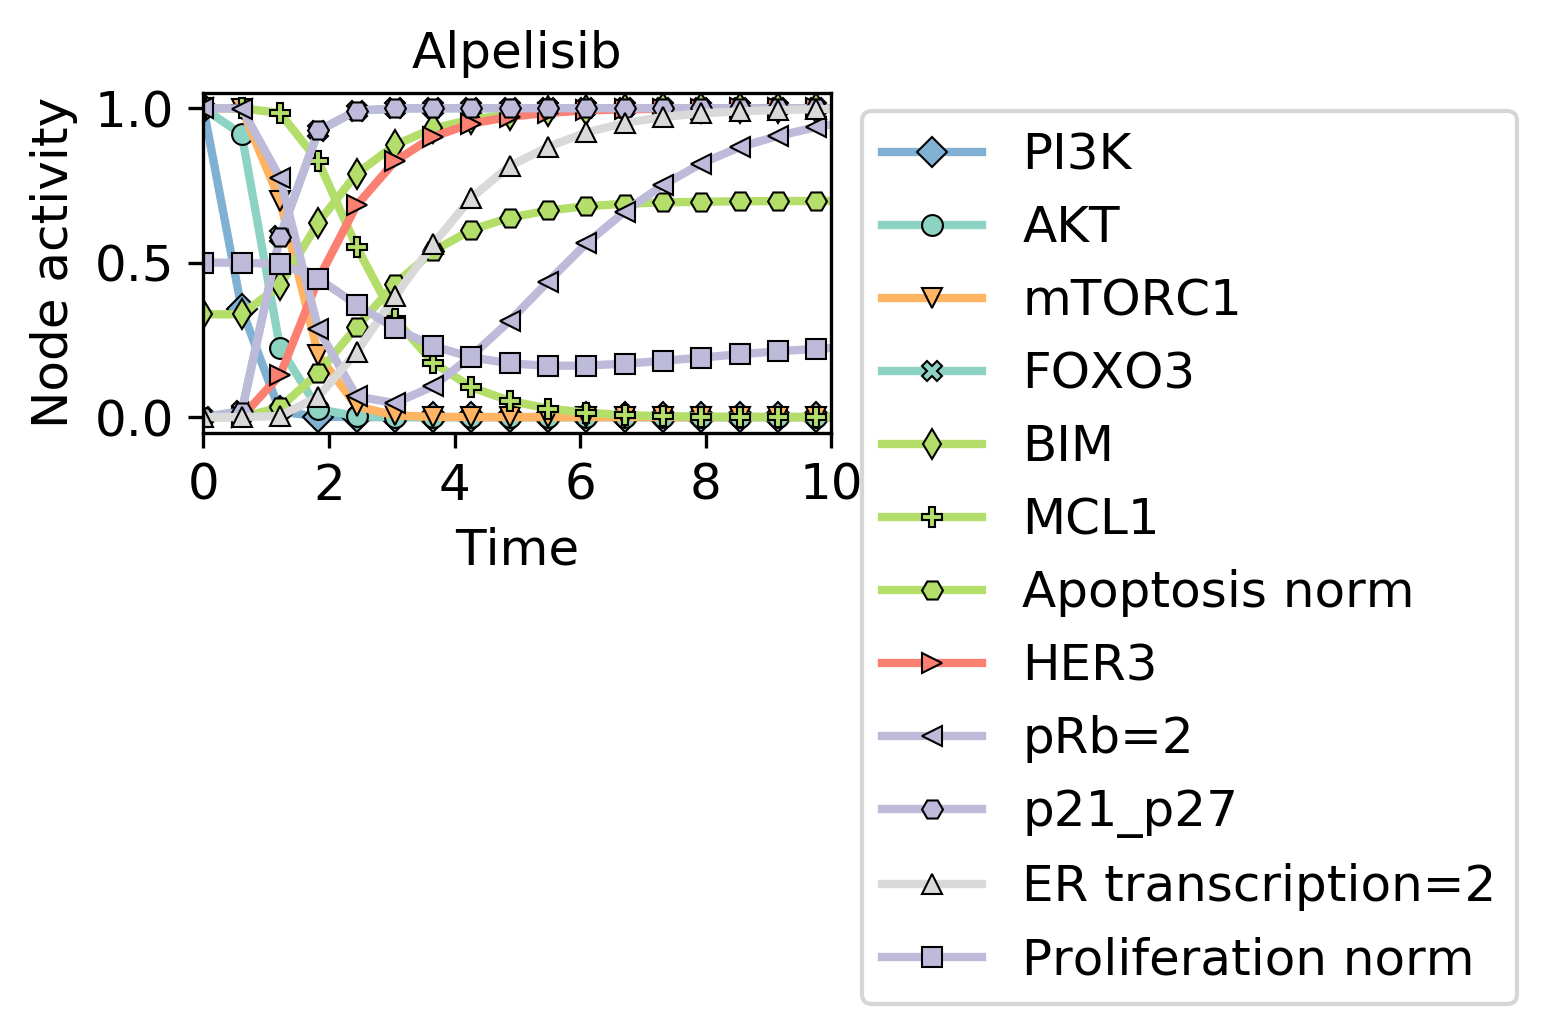

In [35]:
filename='figures/BreastCancerModel_ZanudoEtAl2017_Alpelisib_1'
df_plot=df_timecourse_alpelisib_1.iloc[::3, :]
ax = plt.gca()
df_plot.plot(kind='line',x='time',y='PI3K', marker='D',linestyle='-',c="#80b1d3",markeredgecolor = 'black',ax=ax)
df_plot.plot(kind='line',x='time',y='AKT', marker='o',linestyle='-',c="#8dd3c3",markeredgecolor = 'black',ax=ax)
df_plot.plot(kind='line',x='time',y='mTORC1',marker='v',linestyle='-',color="#feb462",markeredgecolor = 'black',ax=ax)
df_plot.plot(kind='line',x='time',y='FOXO3',marker='X',linestyle='-',c="#8dd3c3",markeredgecolor = 'black',ax=ax)
df_plot.plot(kind='line',x='time',y='BIM',marker='d',linestyle='-',c="#b3de69",markeredgecolor = 'black',ax=ax)
df_plot.plot(kind='line',x='time',y='MCL1',marker='P',linestyle='-',c="#b3de69",markeredgecolor = 'black',ax=ax)
df_plot.plot(kind='line',x='time',y='Apoptosis_norm',marker='H',linestyle='-',c="#b3de69",markeredgecolor = 'black',ax=ax)
df_plot.plot(kind='line',x='time',y='HER3',marker='>',linestyle='-',c="#fb8072ff",markeredgecolor = 'black',ax=ax)
df_plot.plot(kind='line',x='time',y='pRb_2',marker='<',linestyle='-',c="#bebada",markeredgecolor = 'black',ax=ax)
df_plot.plot(kind='line',x='time',y='p21_p27',marker='H',linestyle='-',c="#bebada",markeredgecolor = 'black',ax=ax)
df_plot.plot(kind='line',x='time',y='ER_transcription_2',marker='^',linestyle='-',color="#d9d9d9",markeredgecolor = 'black',ax=ax)
df_plot.plot(kind='line',x='time',y='Proliferation_norm',marker='s',linestyle='-',c="#bebada",markeredgecolor = 'black',ax=ax)
plt.legend(['PI3K','AKT','mTORC1',"FOXO3","BIM","MCL1",'Apoptosis norm',"HER3","pRb=2","p21_p27","ER transcription=2",'Proliferation norm'],bbox_to_anchor=(1.01, 1.02), loc=2, prop={'size':12})
#ax.get_legend().remove()
plt.ylabel('Node activity')
plt.xlabel('Time')
plt.title("Alpelisib", fontsize=12)
xticks([0, 2, 4, 6, 8,10], ['0', '2', '4','6','8','10'])
plt.xlim([0,10])
plt.ylim([-0.05,1.05])
savefig(filename+'_t0-10.svg', bbox_inches='tight',dpi=450)
savefig(filename+'_t0-10.png', bbox_inches='tight',dpi=300)
plt.close()
Image(filename=filename+"_t0-10.png")